### 1. 이 데이터는 믿을만할까?
- 1. 결측, 이상치, 편향을 점검하고 처리 기준을 제시
- 2. MedHouseValue가 0이거나 극단값인지, Medlnc/HouseAge/AveRooms 등 주요 변수의 범위가 현실적인지 확인
- 3. 1940년 이전 건축 주택이 52로 코딩되는 이유를 이해하고, 분석에 미칠 영향을 검토
- 4. 전처리 전,후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만듦
- 5. 단위, 해석 주의: MedHouseValue는 실제 달러 단위입니다. 1990년 명목가를 참고해 현실성을 평가하세요.

In [2]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas import DataFrame

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import spearmanr

from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
origin = load_data('california_housing')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/california_housing.xlsx
[desc] 1990년 미국 인구조사(Census)를 기반으로 캘리포니아 각 지역의 인구·주택·소득 특성과 주택 중위가격을 담아, 회귀 분석과 머신러닝 모델 실습에 널리 사용되는 대표적인 주택 가격 데이터 (출처: https://www.kaggle.com/datasets/camnugent/california-housing-prices)

field               description
------------------  ------------------------------------------------------------------------------
longitude           경도(Longitude). 서경(–값) 기준.
latitude            위도(Latitude). 북위(+) 기준.
housing_median_age  해당 구역(블록 그룹)의 주택 중위 연령(년).
total_rooms         구역 내 모든 주택의 총 방(room) 수 합계.
total_bedrooms      구역 내 모든 주택의 총 침실(bedroom) 수 합계.
population          구역의 전체 인구 수.
households          구역의 전체 “가구 수”(living units).
median_income       구역의 중위 소득(median income), 단위는 약 1 = $10,000 수준.
median_house_value  주택 중위가격(달러). 회귀의 목표변수(타깃).
ocean_proximity     해안과의 거리/접근성 범주: <1H OCEAN, INLAND, NEAR BAY, NEAR OCEAN, ISLAND 등.


===== 데이터 크기 확인 =====
데이터셋 크기 : (20640, 10)
열 개수: 10
행 개수: 20640

===== 데이터 타입 확인 =====
<c

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


결측치 확인

In [5]:
origin.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

total_bedrooms 변수에 전체 건수 20640중 결측치 207건 발견 (1퍼센트에 해당 - 삭제해도 이상 없을 것이라 판단)

In [6]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


이상치 탐색 (MedHouseValue가 0인지, 극단값인지, 주요 변수의 범위가 현실적인지)

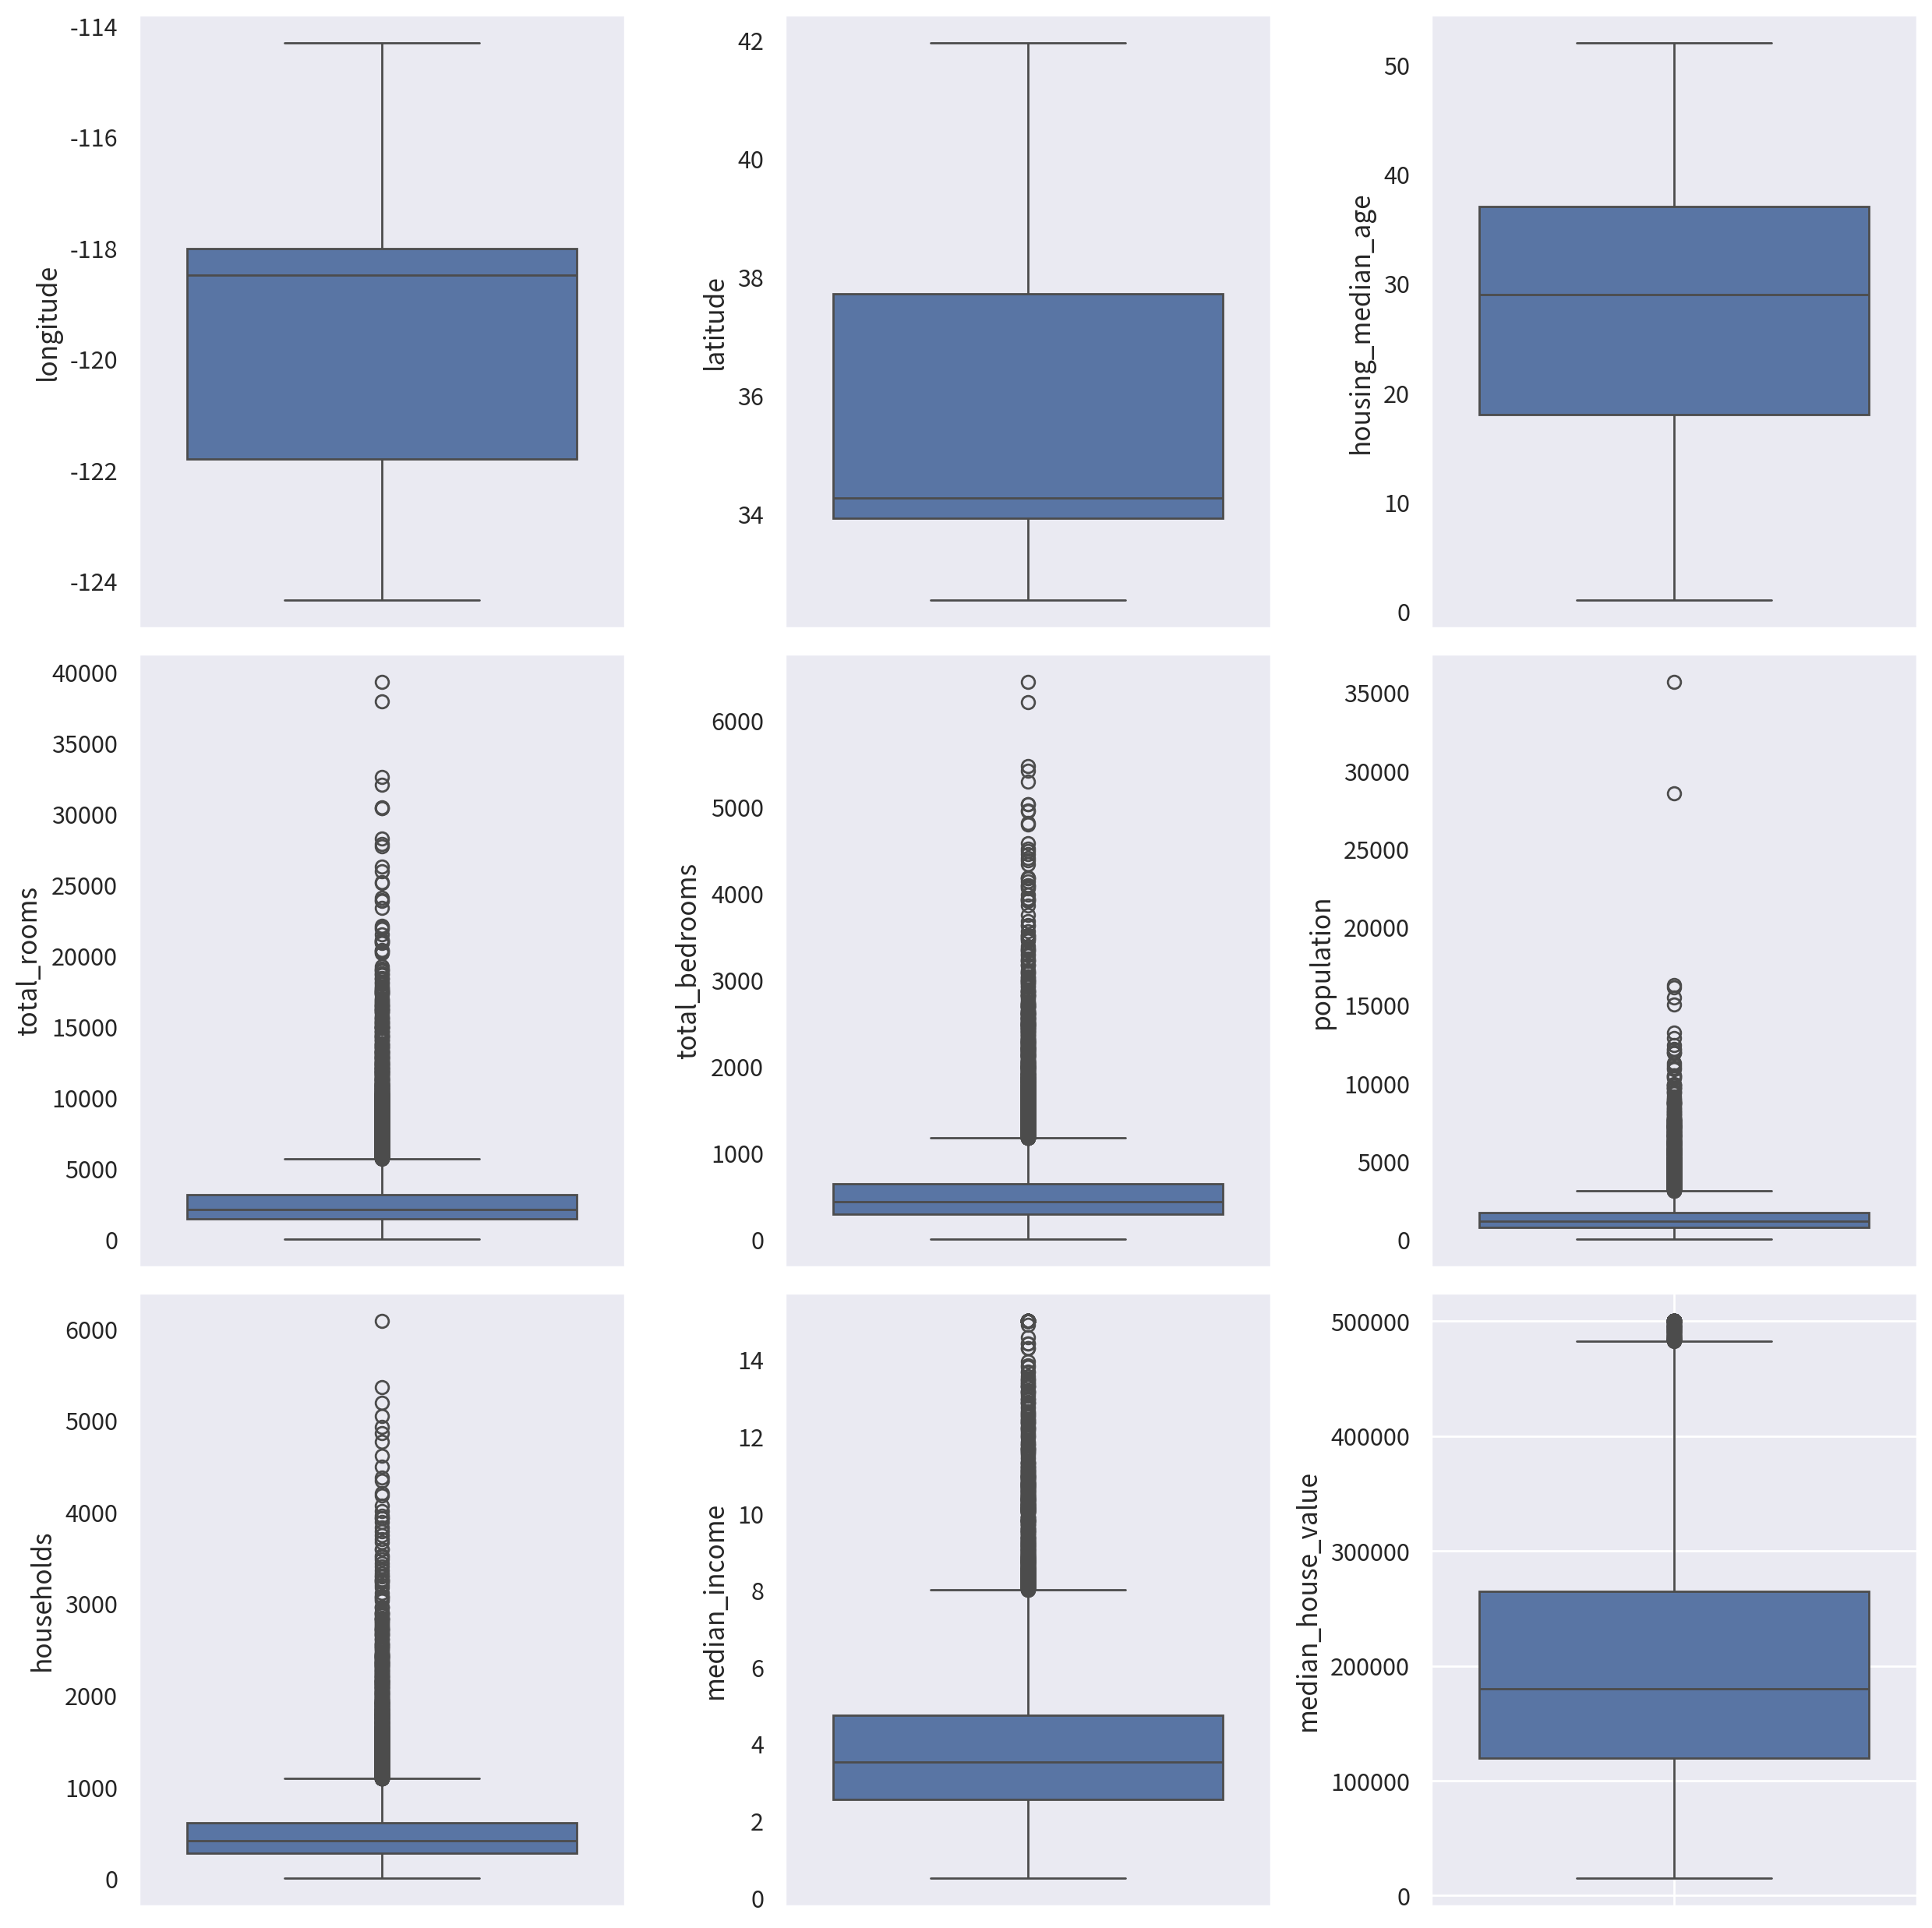

In [7]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=origin['longitude'],orient='v',ax=ax[0][0])
sb.boxplot(data=origin['latitude'],orient='v',ax=ax[0][1])
sb.boxplot(data=origin['housing_median_age'],orient='v',ax=ax[0][2])
sb.boxplot(data=origin['total_rooms'],orient='v',ax=ax[1][0])
sb.boxplot(data=origin['total_bedrooms'],orient='v',ax=ax[1][1])
sb.boxplot(data=origin['population'],orient='v',ax=ax[1][2])
sb.boxplot(data=origin['households'],orient='v',ax=ax[2][0])
sb.boxplot(data=origin['median_income'],orient='v',ax=ax[2][1])
sb.boxplot(data=origin['median_house_value'],orient='v',ax=ax[2][2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

0인 값은 없으며 변수의 범위가 **구역 내** 이므로 이상치가 존재하지만 현실적인 범위라고 생각됨.

1940년 이전 건축 주택이 52로 코딩되는 이유

In [8]:
print(origin['housing_median_age'].describe())
#origin['housing_median_age']값이 52인 것의 개수 출력
origin[origin['housing_median_age'] == 52].shape[0]

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64


1273

- 데이터를 수집하는 단계에서 1940년 이전의 데이터가 없었기 때문에 그 때 당시의 시간 값을 뺀 느낌
- 데이터 총 건수 20640개 중 52에 해당하는 데이터가 1273개 = 전체 데이터 중 6% 해당하는 데이터라 채워 넣어도 상관 없을 것 같다고 판단하여 52로 채워넣은듯.
- 분석에는 1940년전 건물로 분석이 될 것임. 극단적으로 1940년전이 많이 나오진 않을듯

- 필요한 전처리는 total_bedrooms의 결측치인 207개 값을 삭제하는 것
    - 삭제의 근거는 총 데이터 20640개중 1% 정도 되는 것으로 확인하여 삭제해도 될 것 같다고 판단


In [9]:
# total_bedrooms 결측치 제거
df = origin.copy()
df = df.dropna(subset=['total_bedrooms'])
df = df.astype({'ocean_proximity':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  int64   
 3   total_rooms         20433 non-null  int64   
 4   total_bedrooms      20433 non-null  float64 
 5   population          20433 non-null  int64   
 6   households          20433 non-null  int64   
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  int64   
 9   ocean_proximity     20433 non-null  category
dtypes: category(1), float64(4), int64(5)
memory usage: 1.6 MB


- 삭제하기 전 원본 데이터 개수 20640
    - 삭제 후 데이터 개수 20433 , 207개 제거 완료

In [10]:
df['median_house_value'].describe()

count     20433.000000
mean     206864.413155
std      115435.667099
min       14999.000000
25%      119500.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64

- 50만 달러 현 시세로 7억 4천만원 가량
    - 현실성 매우 있음

### 미션 2. 가격과 핵심 변수의 첫인상
- 1. MedHouseValue, Medlnc, HouseAge, AveRooms 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다.
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술하시오.
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
- 4. 지역별(Latitude/Longitude)편향이나 시계열 문제(1990년 데이터만)가 해석에 미치는 영향도 짧게 언급하세요.

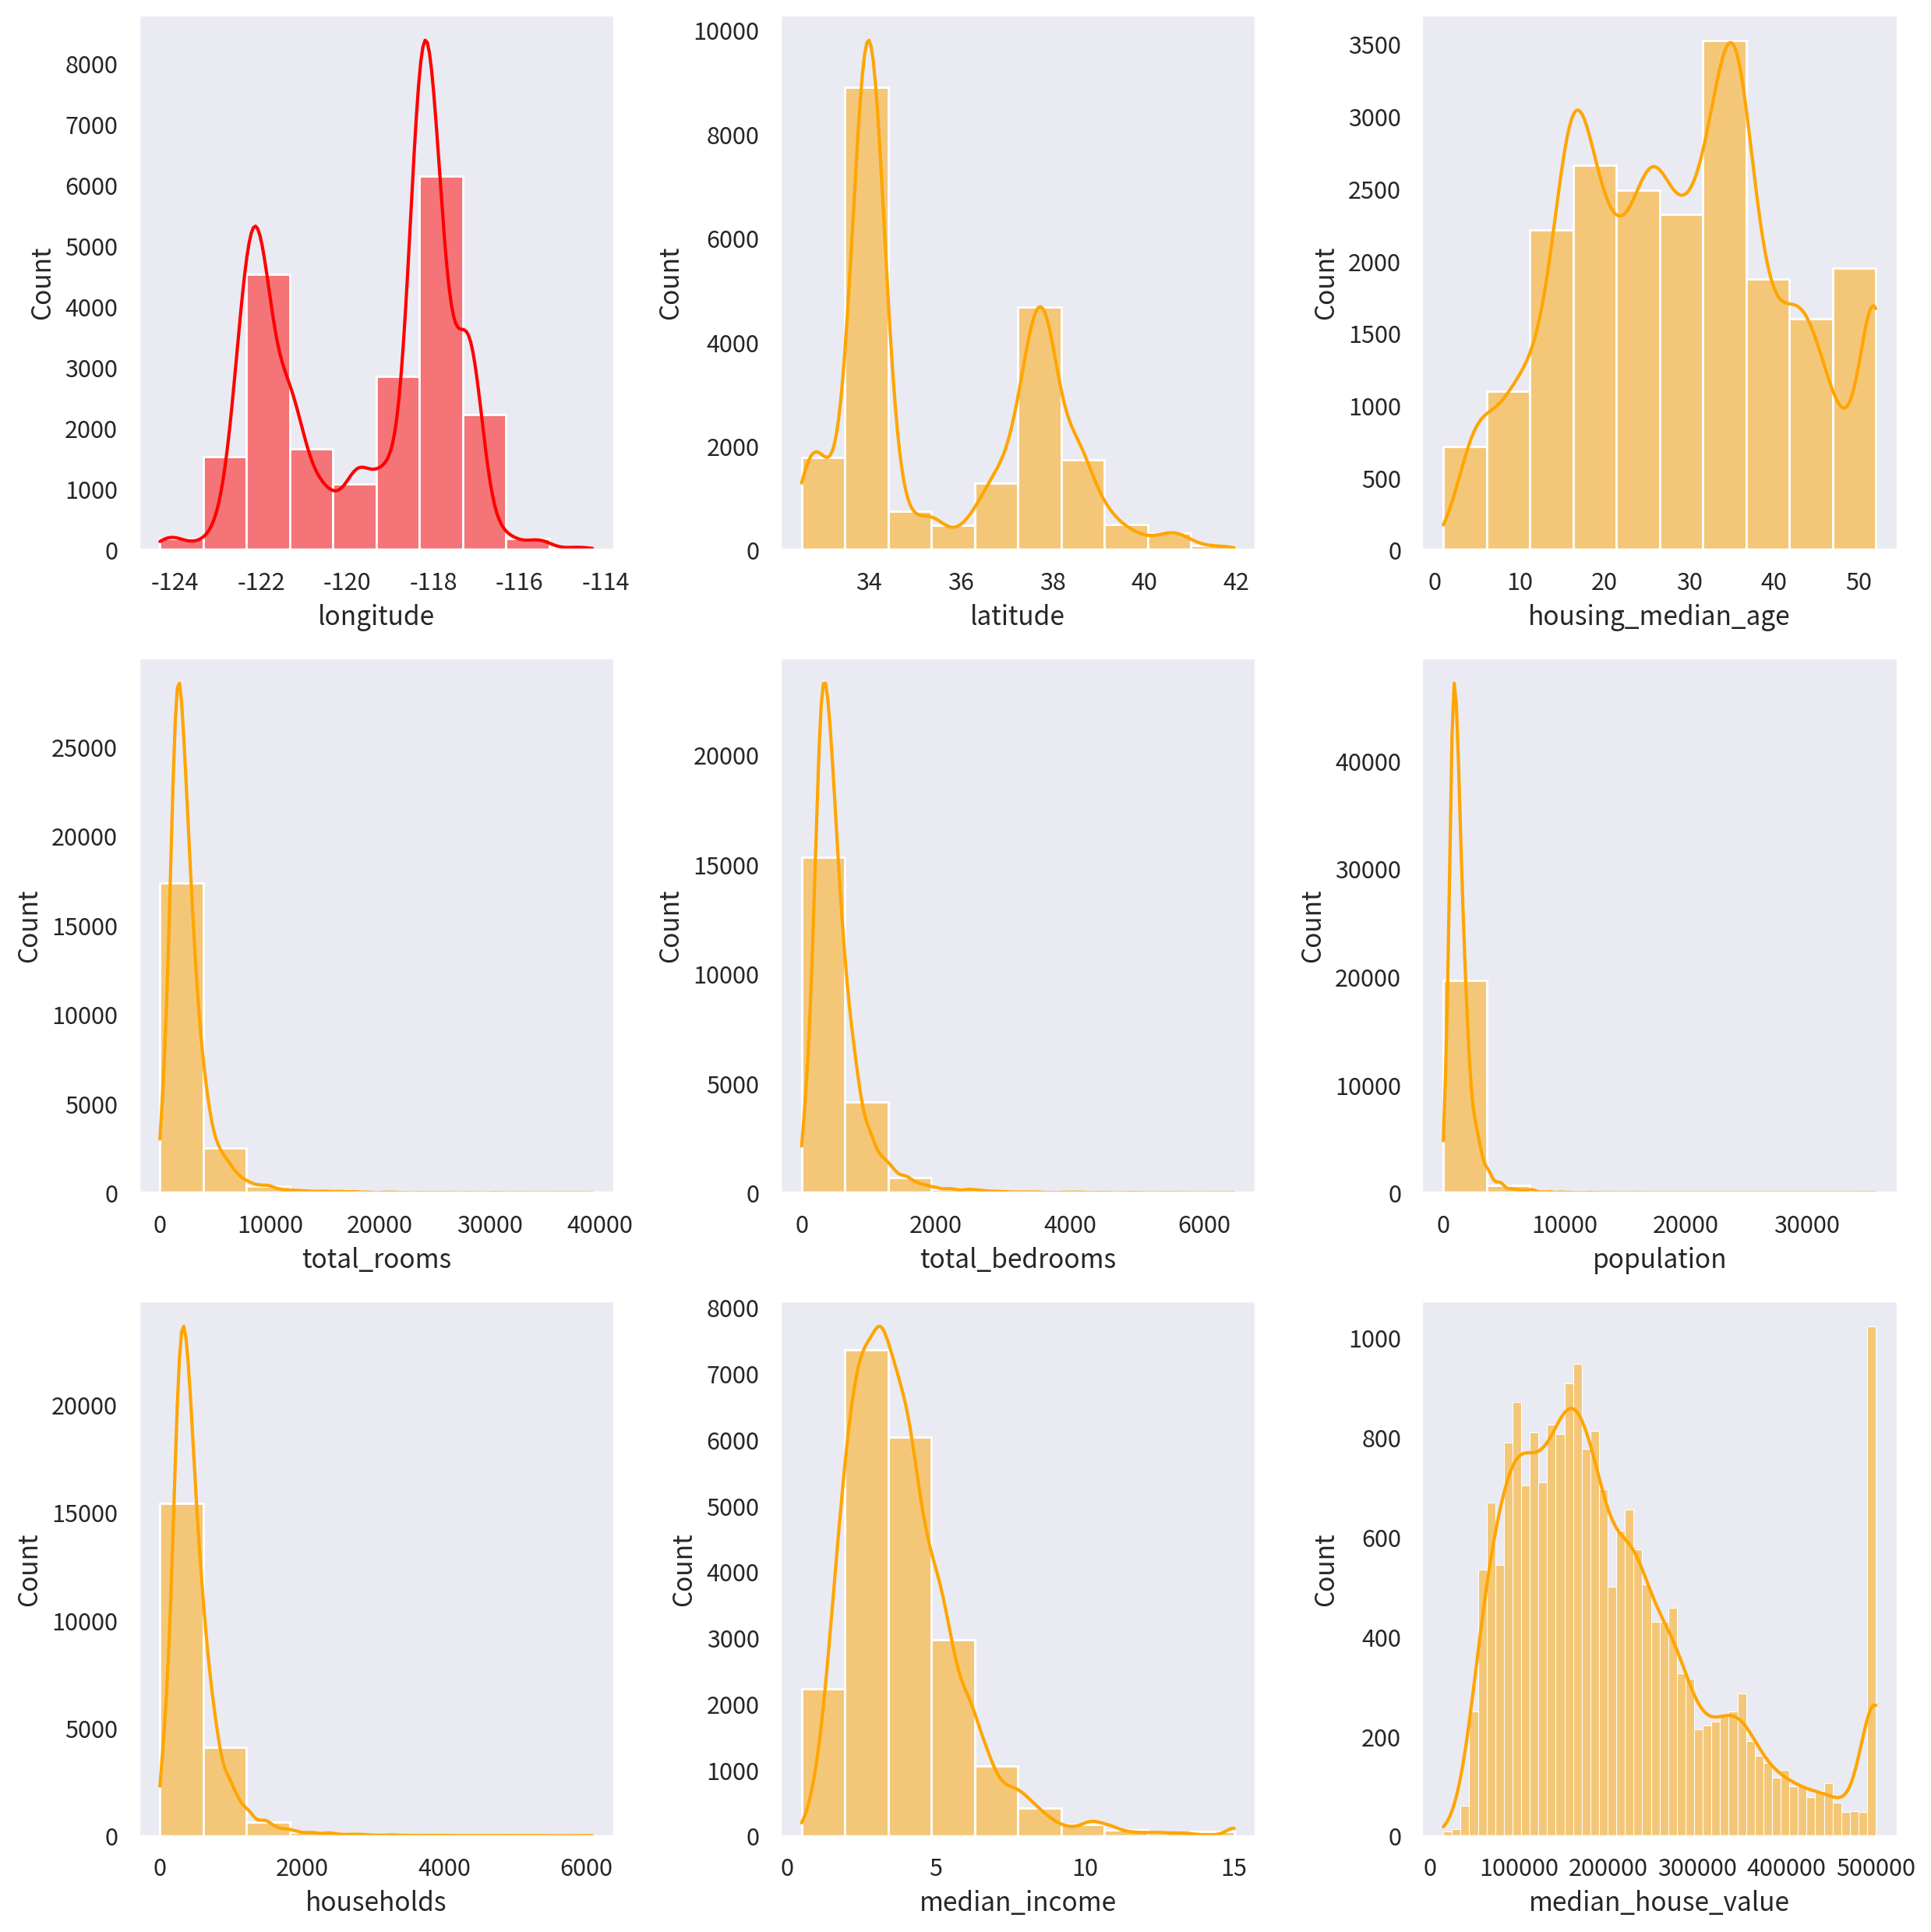

In [11]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df, x='longitude', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df, x='latitude', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df, x='housing_median_age', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df, x='population', bins=10, kde=True, color='orange',ax=ax[1,2])
sb.histplot(data=df, x='households', bins=10, kde=True, color='orange',ax=ax[2,0])
sb.histplot(data=df, x='median_income', bins=10, kde=True, color='orange',ax=ax[2,1])
sb.histplot(data=df, x='median_house_value', bins=50, kde=True, color='orange',ax=ax[2,2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 34, 38, -122, -118 부근에 구역이 많이 위치하고 있다.
- 구역의 집의 나이 중앙값은 10년 미만의 값이 거의 없다 (1000건대)
    - 신축이라고 볼 수 있는 집이 거의 없음
- 구역의 방 개수, 침실 개수, 인구수, 가구수는 그래프 상 왼쪽에 치우쳐져 있다.
- median_income 과 median_house_value는 왼쪽으로 치우쳐있으며 오른쪽 꼬리가 존재함
    - 전반적으로 데이터가 오른쪽 꼬리가 존재
    - > 소수의 좋은 집이 꼬리를 만들고 있음

In [12]:
# 종속 변수 제거
df2 = df.drop(columns='ocean_proximity')
# 왜도 계산
df2_skewness = df2.skew().sort_values(ascending=False)
# print(df2_skewness)
# 왜도가 1 이상이면 추출
im_skew = df2_skewness[abs(df2_skewness) > 1]
print("왜도가 심한 변수:\n",im_skew)

왜도가 심한 변수:
 population        4.960017
total_rooms       4.158816
total_bedrooms    3.459546
households        3.413850
median_income     1.644557
dtype: float64


- 왜도가 심하면 극단적인 값이 존재한다는 것인데 (한쪽으로 치우침), 정규분포를 따르지 않는다는 것이고 예측에 대해 부정확해짐
- 왜도가 심한 변수는 다른 변수들과의 선형 관계를 파악하기 어렵게 만듦
    - 이러한 변수들은 종속 변수에 더 중요한 영향을 미치는지 판단하는 오즈비 해석의 신뢰도를 떨어뜨림
- 실제 캘리포니아의 주거 특징이라면 왜도를 바꾸지 않고 진행해도 될 듯함
    - 하지만 모델의 성능 차이가 심할 수 있음
    - 로그 변환한 데이터와 변환하지 않은 데이터를 가지고 AUC 성능 비교 진행

### 미션 3. 로그/비선형 변환을 고민해보자.
- 1. MedHouseValue 혹은 주요 변수 (Medlnc, Population, HouseAge)에 로그/제곱근 등 변환을 적용해 전 후 분포를 나란히 비교한다.
- 2. 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상한다.
- 3. 이 변환이 없으면 어떤 함정에 빠질까? 를 한 줄로 정리한다.
- 4. 선택 기준을 명시하세요: 왜 log(MedHouseValue)인지, 왜 Population에 로그인지 등 데이터 분포 근거로 설명합니다.

In [13]:
df2_log = df2.copy()
# 1. MedHouseValue, Medlnc, Population, HouseAge 변수에 로그 변환 후 다시 계산
df2_log['median_income'] = np.log1p(df2['median_income'])
df2_log['population'] = np.log1p(df2['population'])
df2_log['total_rooms'] = np.log1p(df2['total_rooms'])
df2_log['total_bedrooms'] = np.log1p(df2['total_bedrooms'])
df2_log['households'] = np.log1p(df2['households'])
df2_log_skewness = df2_log.skew().sort_values(ascending=False)
print("로그 변환 후 왜도:\n", df2_log_skewness)

로그 변환 후 왜도:
 median_house_value    0.978290
latitude              0.464934
median_income         0.224597
housing_median_age    0.061605
longitude            -0.296141
total_bedrooms       -0.992813
population           -1.048037
households           -1.056801
total_rooms          -1.081242
dtype: float64


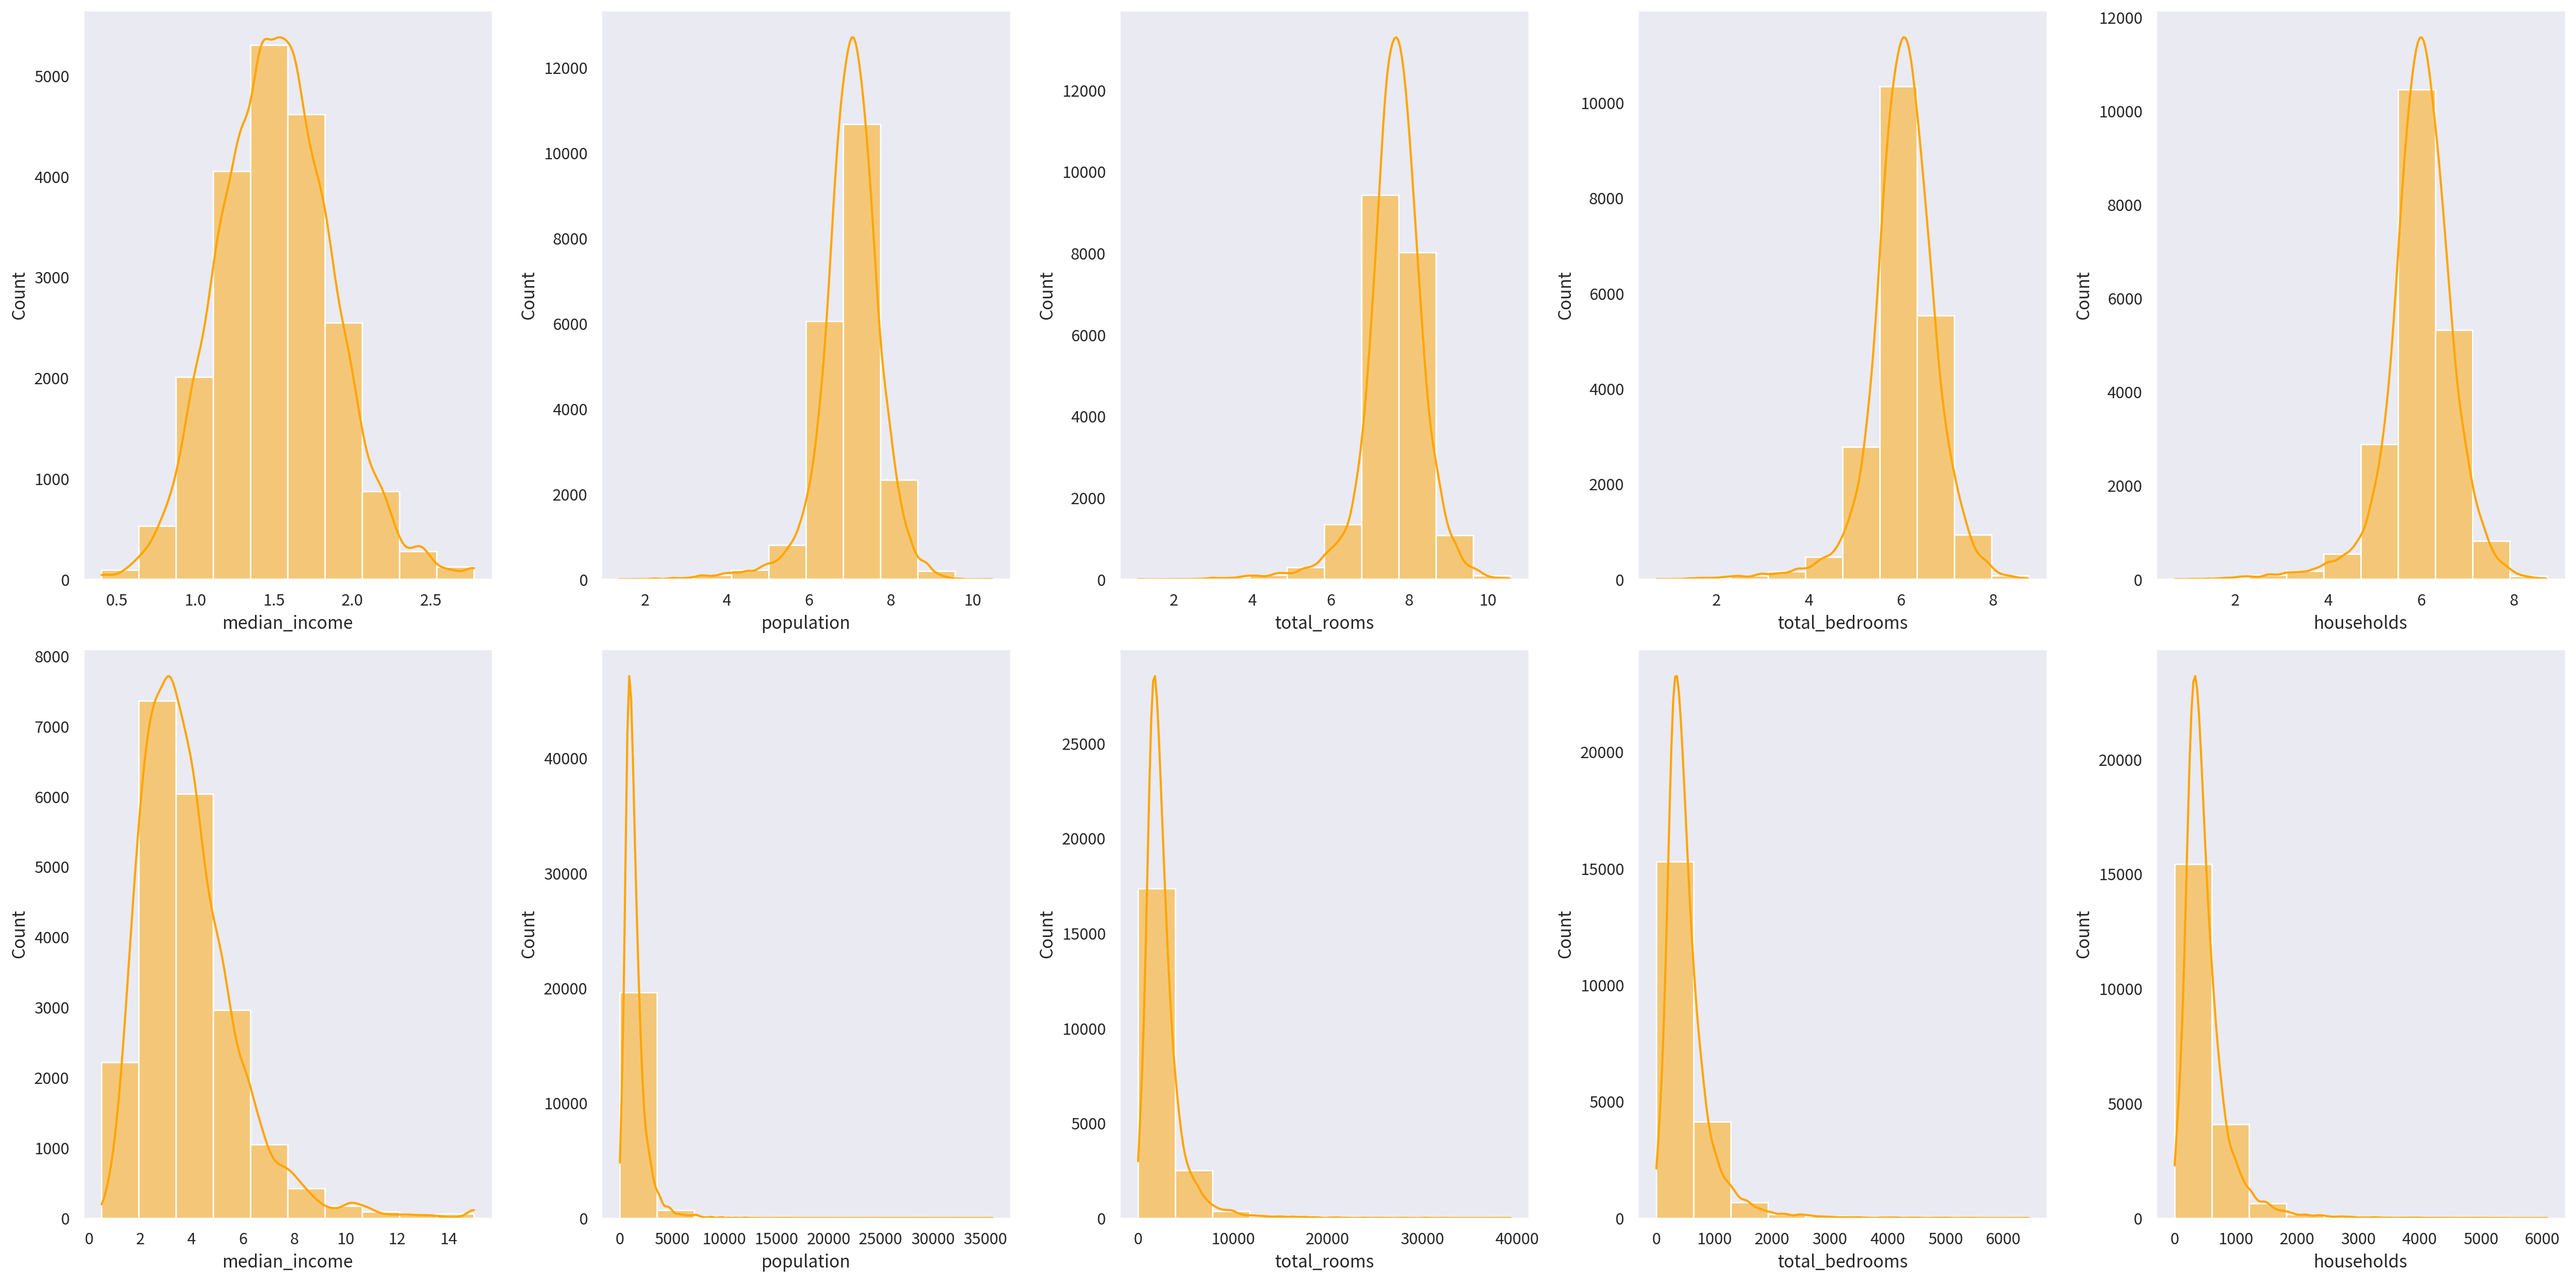

In [14]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 5000             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 2                    #도화지의 행 수
cols = 5                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df2_log, x='median_income', bins=10, kde=True, color='orange', ax=ax[0,0])
sb.histplot(data=df2_log, x='population', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df2_log, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df2_log, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[0,3])
sb.histplot(data=df2_log, x='households', bins=10, kde=True, color='orange', ax=ax[0,4])
# 비교를 위한 로그 변환 전 그래프
sb.histplot(data=df2, x='median_income', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df2, x='population', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df2, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[1,2])
sb.histplot(data=df2, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,3])
sb.histplot(data=df2, x='households', bins=10, kde=True, color='orange', ax=ax[1,4])

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 분포가 변환하기 전보다 한쪽으로 치우지지 않게끔 처리됨
    - 밑이 변환하기 전, 위가 변환 후의 모습
    - 정규 분포에 가깝게 만들어줌 => 모델이 안정적인 결과를 도출해낼 확률이 올라감
    - 변환하기 전이라면 극단적인 값이 많기 때문에 해당 값들의 영향력이 셀 것
- log를 취한 변수들의 기준
    - 분포 상 한쪽으로 치우침이 많은 변수들(왜도가 1 이상인 변수)을 설정
- 해당 변환이 없으면 왜도가 심하기 때문에 극단값들에 의해 결과 분석이 이상하게 될 수 있음

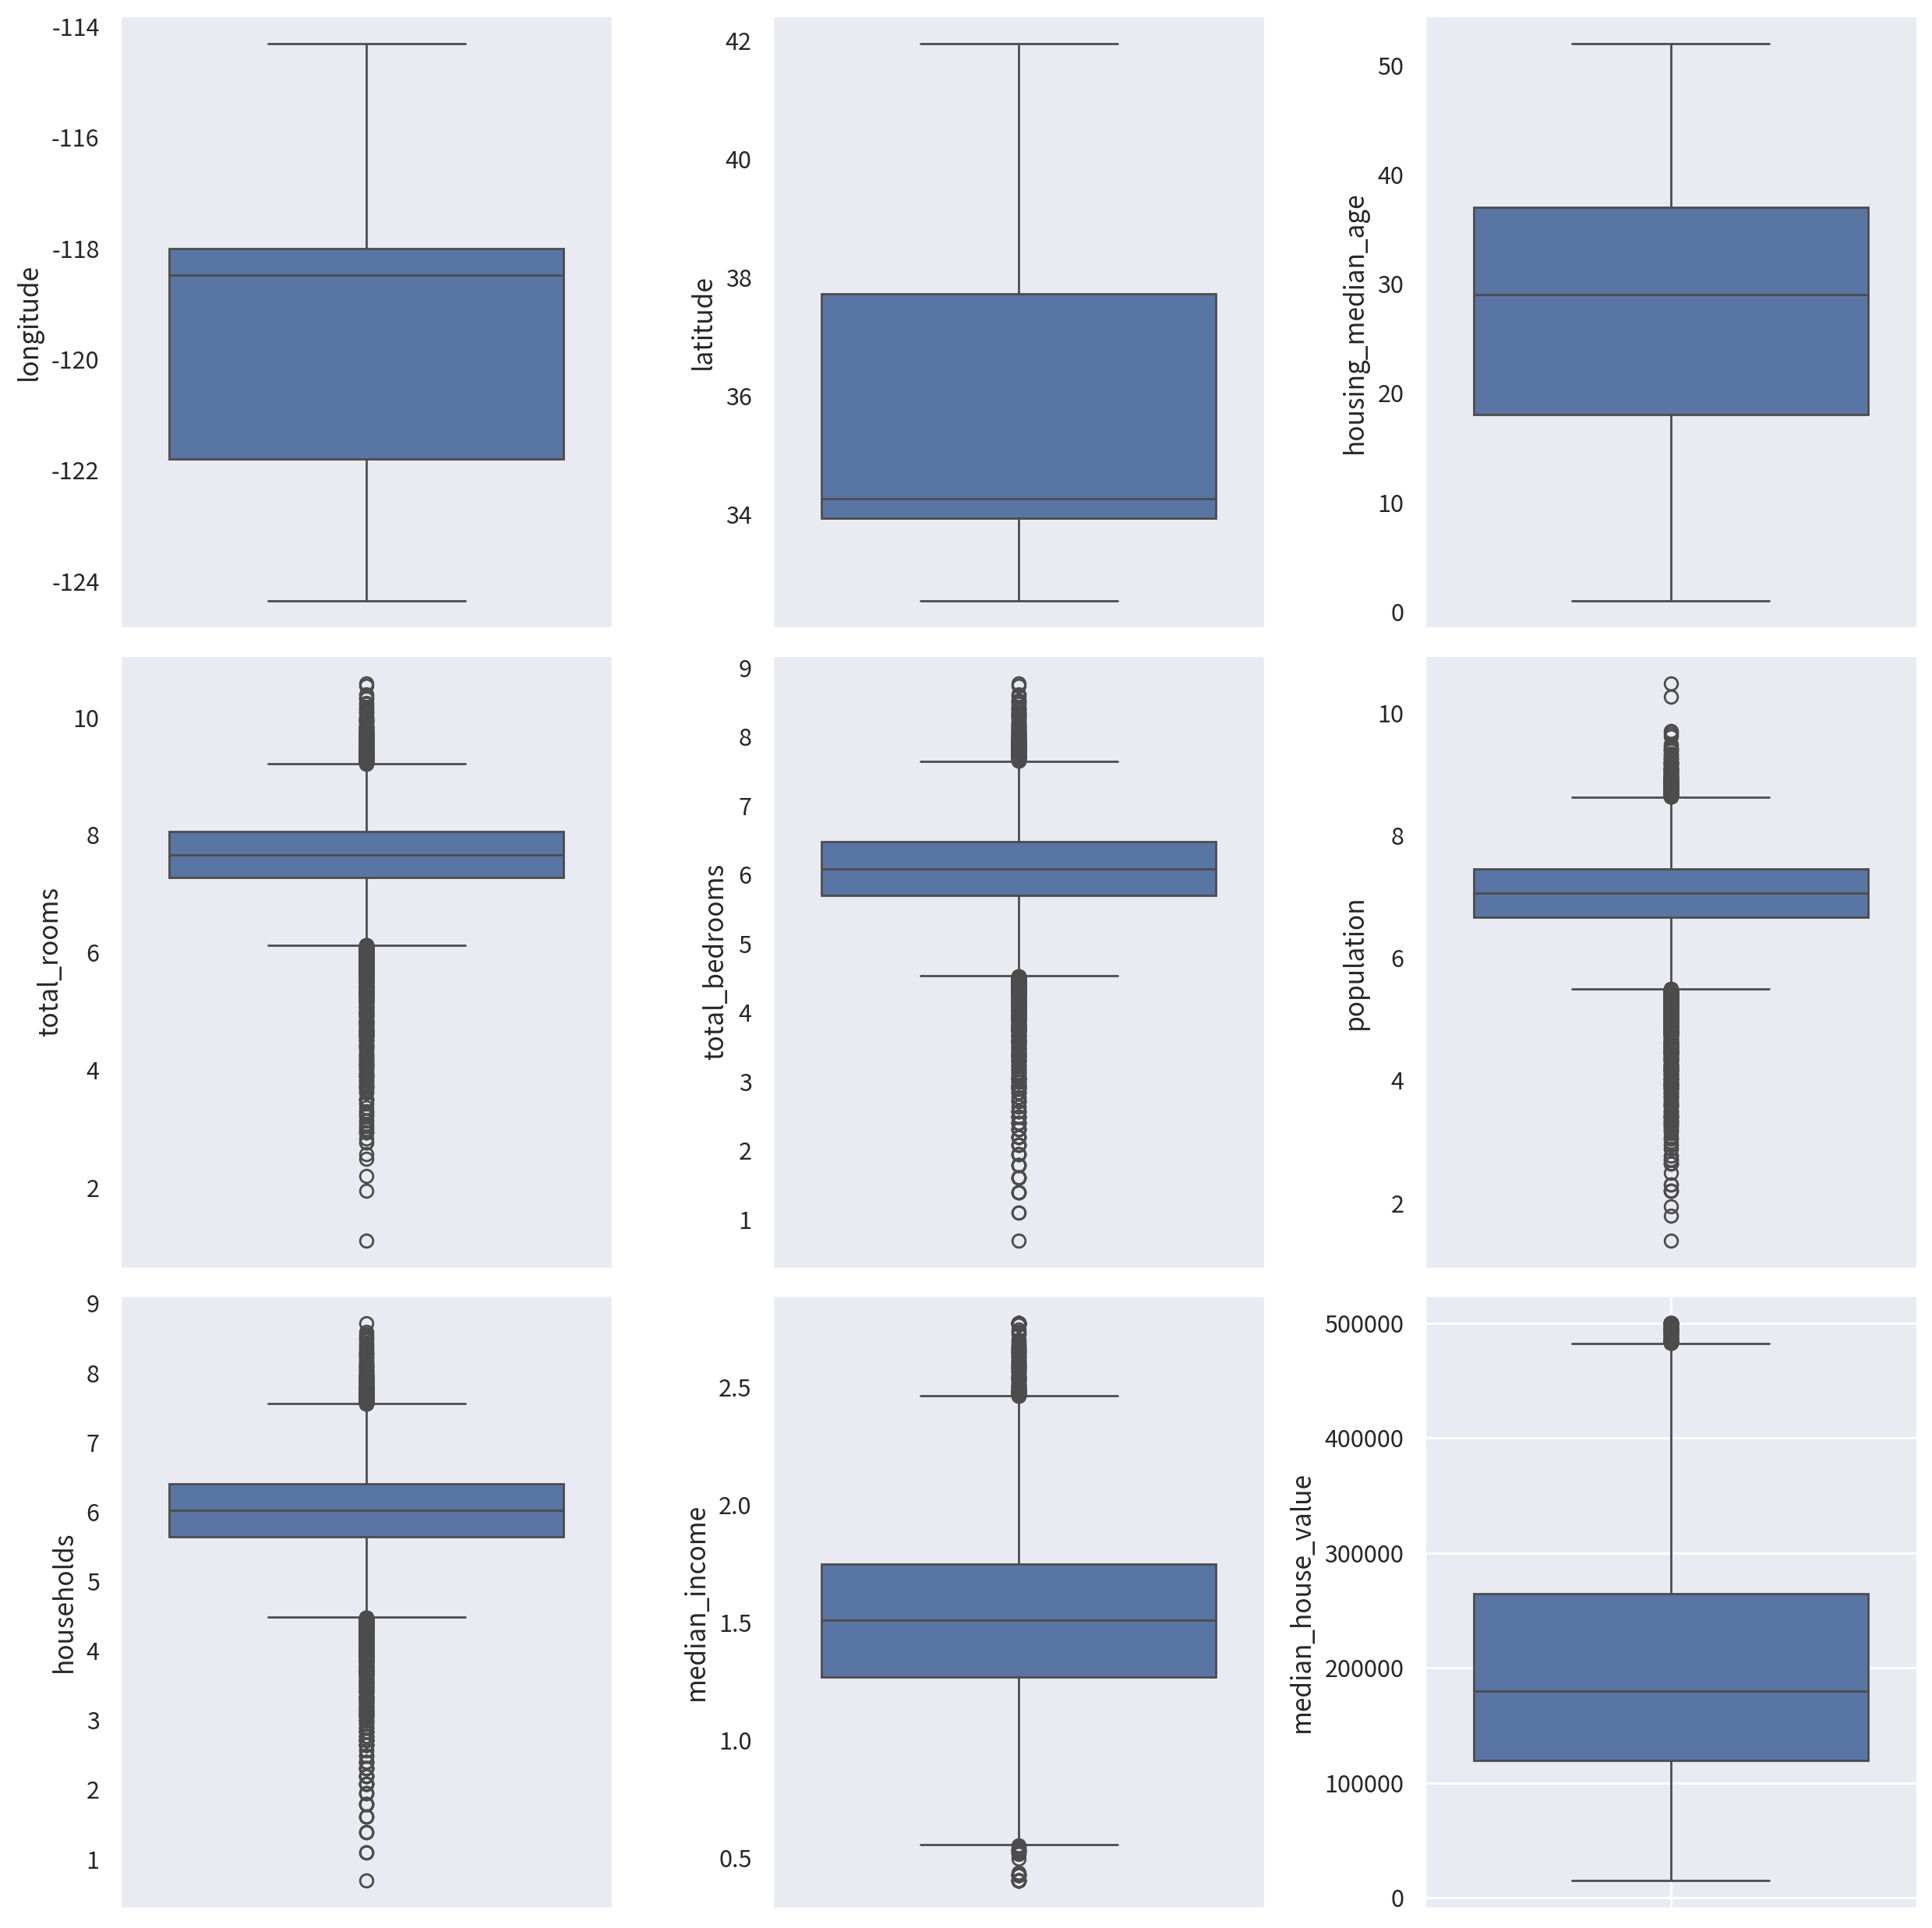

In [15]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df2_log['longitude'],orient='v',ax=ax[0][0])
sb.boxplot(data=df2_log['latitude'],orient='v',ax=ax[0][1])
sb.boxplot(data=df2_log['housing_median_age'],orient='v',ax=ax[0][2])
sb.boxplot(data=df2_log['total_rooms'],orient='v',ax=ax[1][0])
sb.boxplot(data=df2_log['total_bedrooms'],orient='v',ax=ax[1][1])
sb.boxplot(data=df2_log['population'],orient='v',ax=ax[1][2])
sb.boxplot(data=df2_log['households'],orient='v',ax=ax[2][0])
sb.boxplot(data=df2_log['median_income'],orient='v',ax=ax[2][1])
sb.boxplot(data=df2_log['median_house_value'],orient='v',ax=ax[2][2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

### 미션 4. 지리적 위치는 정말 중요할까?
- 1. 위도와 경도를 활용한 지리적 시각화를 수행한다.
- 2. 산점도(경도 X 위도, 점의 색상 = MedHouseValue)를 그려 주택 가격의 지리적 불평등을 관찰한다.
- 3. 어느 지역이 비싼가?, 가격 차이가 얼마나 뚜렷한가? 를 데이터 기반으로 설명하세요.
- 4. 위도/경도가 개별 변수보다 지역 표상(Proxy)이라는 점을 인식하고 이것이 회귀에 주는 의미를 논의하세요.

지리적 시각화 수행 : 산점도 그래프를 이용하여 진행

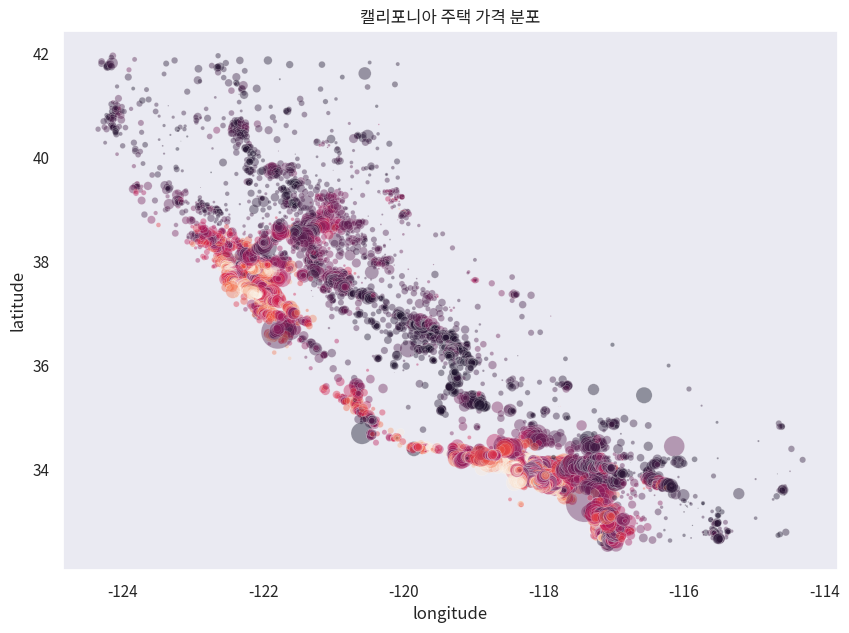

In [16]:
plt.figure(figsize=(10, 7))
# s: 점의 크기(인구수 비례), c: 색상(주택 가격 비례해서 진하게)
sb.scatterplot(data=df2, x='longitude', y='latitude', 
                alpha=0.4, s=df2['population']/50,   
                c=df2['median_house_value'])
plt.title('캘리포니아 주택 가격 분포')
plt.show()

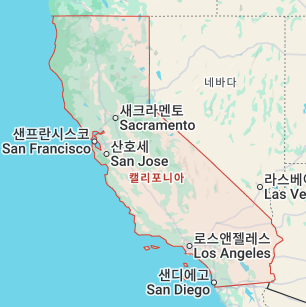
- 모여 살고 있는 곳은 (34,-117), (38,-122) ~ (38,-121)
- 진한색만 나타나는 (40,-122), (36,-120~119), (34,-116) 위치는 고액의 주거단지라고 볼 수 있음.
- 색상 차이가 확연함 (진한 곳은 진한 색만, 밝은 곳은 완전 밝은색끼리 뭉쳐있음)
- 위도/경도가 개별 변수보다 지역 표상(Proxy)이라는 점을 인식하고, 이것이 회귀에 주는 의미를 논의
    - 위도 경도의 경우 한쪽으로 치우친다고 해서 다른 변수들처럼 로그 변환을 진행하게 되면 실제 지리적 위치가 바뀌게 되어 해석이 망가짐
    - 실제 데이터이기도 하고 위치에서 주는 데이터 자체가 중요하기 때문
    - 결국 최종 목표가 명목 주택 중위 가격을 설명하는 구조를 이해하는 것이고, 주택 중위 가격을 설명하는 것이 위치에 따른 (중심지일수록 비싸다?, 외곽에는 비싼 주택이 없을것이다?)것도 고려해보아야 하기 때문에 변환하면 안됨.
        - 그래야 회귀에서 지리적 위치에 따른 것에 대한 인사이트를 제공할 수 있음.

In [17]:
df2_log['median_house_value'].value_counts()

median_house_value
500001    958
137500    119
162500    116
112500    103
187500     92
         ... 
321700      1
300800      1
393100      1
203600      1
374600      1
Name: count, Length: 3833, dtype: int64

### 미션 5. 소득은 정말로 집값을 결정할까?

- Medlnc(중위 가구 소득)에 따라 MedHouseValue가 다른지 시각화하고, 선형성과 강도를 평가한다.
- 산점도와 함께 회귀선을 그려 관계의 형태를 관찰하세요.
- 상관계수(Pearson)를 계산하고, "정말로 소득이 집값의 주 결정 요인인가?"를 비판적으로 생각해 보자.
- 소득 수준에 따른 주택가격 불평등 문제를 해석 관점에서 논의하세요.
    - (36,-120~-119)의 경우 지도 상으로도 중심이며 소득 수준이 높은 것을 유추할 수 있음.
    - 중심지로부터 벗어나야 밝은 색이 등장하는 것으로 보아 한국으로 비유하면 서울에 회사가 뭉쳐있지만 서울 중심지는 주택 가격이 높아 살지 못하고 외곽으로 벗어나는 경우가 많은데 캘리포니아도 비슷한 가격 형성이 되어 있는 거 같음.
    - 외곽 지역에 주택 가격이 싸지만 과연 소득 수준이 낮을지는 분석을 진행해봐야 함
        - 실제로 중심지로 출근해서 소득은 높지만 돈을 모으기 위해 싼 곳에 살 수 있기 때문

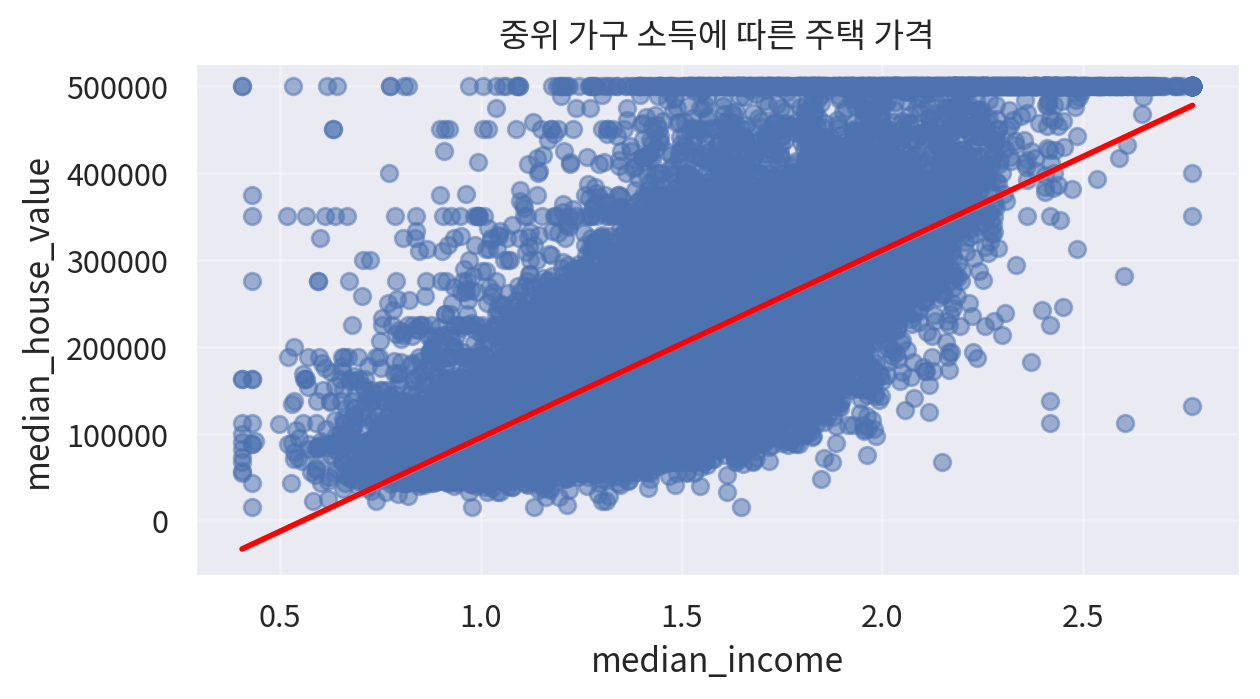

In [18]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=df2_log, x='median_income', y='median_house_value',
           scatter_kws={'alpha':0.5},
           line_kws={'color':'red', 'linewidth':2})
plt.title('중위 가구 소득에 따른 주택 가격')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

- 500000에 해당하는 데이터가 약 958건 존재
    - 그래도 우상향하는 선형적 패턴이 관찰됨
    - 회귀선 주위로 데이터 분포가 이뤄지는 것을 보아 소득이 주택 가격을 결정하는 독립변수로써 힘이 강하다는 것을 알 수 있음
    - 저소득 구간에 고액의 집값이 꽤 많이 존재함
- 상관계수 계산, 정말로 소득이 집값의 주 결정 요인인지 비판적 사고

In [19]:
x = df2_log['median_income']
y = df2_log['median_house_value']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 위반 (p-value: 0.0000)


- 아무래도 500000에 해당하는 958건의 데이터때문에 선형성 위반이라고 나오는 듯. 

In [20]:
import pandas as pd
data = df2_log[['median_income','median_house_value']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계산
    skew_original = temp.skew()

    # Z-scoore 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    #로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count,
        'log_recommend': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z| > 3)'] >0])>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z| > 3),log_recommend
median_income,0.224597,-0.146669,122,False
median_house_value,0.97829,-1.297926,0,False


이상치가 발견되어 스피어만 상관계수 사용


In [21]:
spearman_r, spearman_p = spearmanr(df2_log['median_income'], df2_log['median_house_value'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p, "대립" if spearman_p <= 0.05 else "귀무")

'staticstic: 0.677, p-value: 0.000, 대립가설 채택'

- 귀무가설 : 소득은 집값의 주결정요인이 아니다.
- 대립가설 : 소득은 집값의 주결정요인이다.
    - 대립가설 채택
- 소득 수준에 따른 주택가격 불평등 문제를 해석 관점에서 논의하세요
    - 소득이 높지 않은 가구의 주택 가격이 비싼 이유에 대해 알아볼 필요가 있음.
    - 소득이 오를수록 주택 가격도 비싸지는 것으로 보아 주 요인이라고는 볼 수 있음.
    - 저소득 구간에서 고가의 주택이 몇몇 보이지만 대부분 저가의 주택으로 구성됨
        - 이는 선택할 수 있는 주택 가격의 범위가 제한적이라고 볼 수 있음.
    - 고소득 구간으로 갈 수록 주거 선택지가 많아짐
        - 양극화가 일어남
    - 같은 소득이지만 주택 가격의 차이가 많이 남
        - 소득 수준은 주택 가격의 주된 요인이라고 할 수 있지만, 다른 요인의 유무가 주택 가격 형성에 기여를 하고 있다는 것을 알 수 있음.
    - 주택 가격 (500,000, 958건의 데이터) 최댓값이 의미하는 바가 실제로는 50만 달러를 초과하는 값일 수 있음.
        - 실제 집 값이 더 비싸다면, 소득이 같지만 주택 가격의 차이가 더 심하다고 해석될 수 있음.
    - 결론 : 소득이 높으면 집의 선택지가 많아진다, 소득이 같아도 주거 수준이 천차만별이다.

### 미션 6. 주택 특성은 소수일까, 다수일까?
- total_rooms, total_bedrooms, housing_median_age, households, Population의 분포를 확인한다.
- 각 변수별로 생존자(정상) vs 이상치를 구분하고, 회귀에 미칠 영향을 평가하세요.
- 일부 극단값(예: 매우 작은 방의 수, 매우 높은 인구밀도)이 전체 분석을 왜곡할 가능성을 검토합니다.

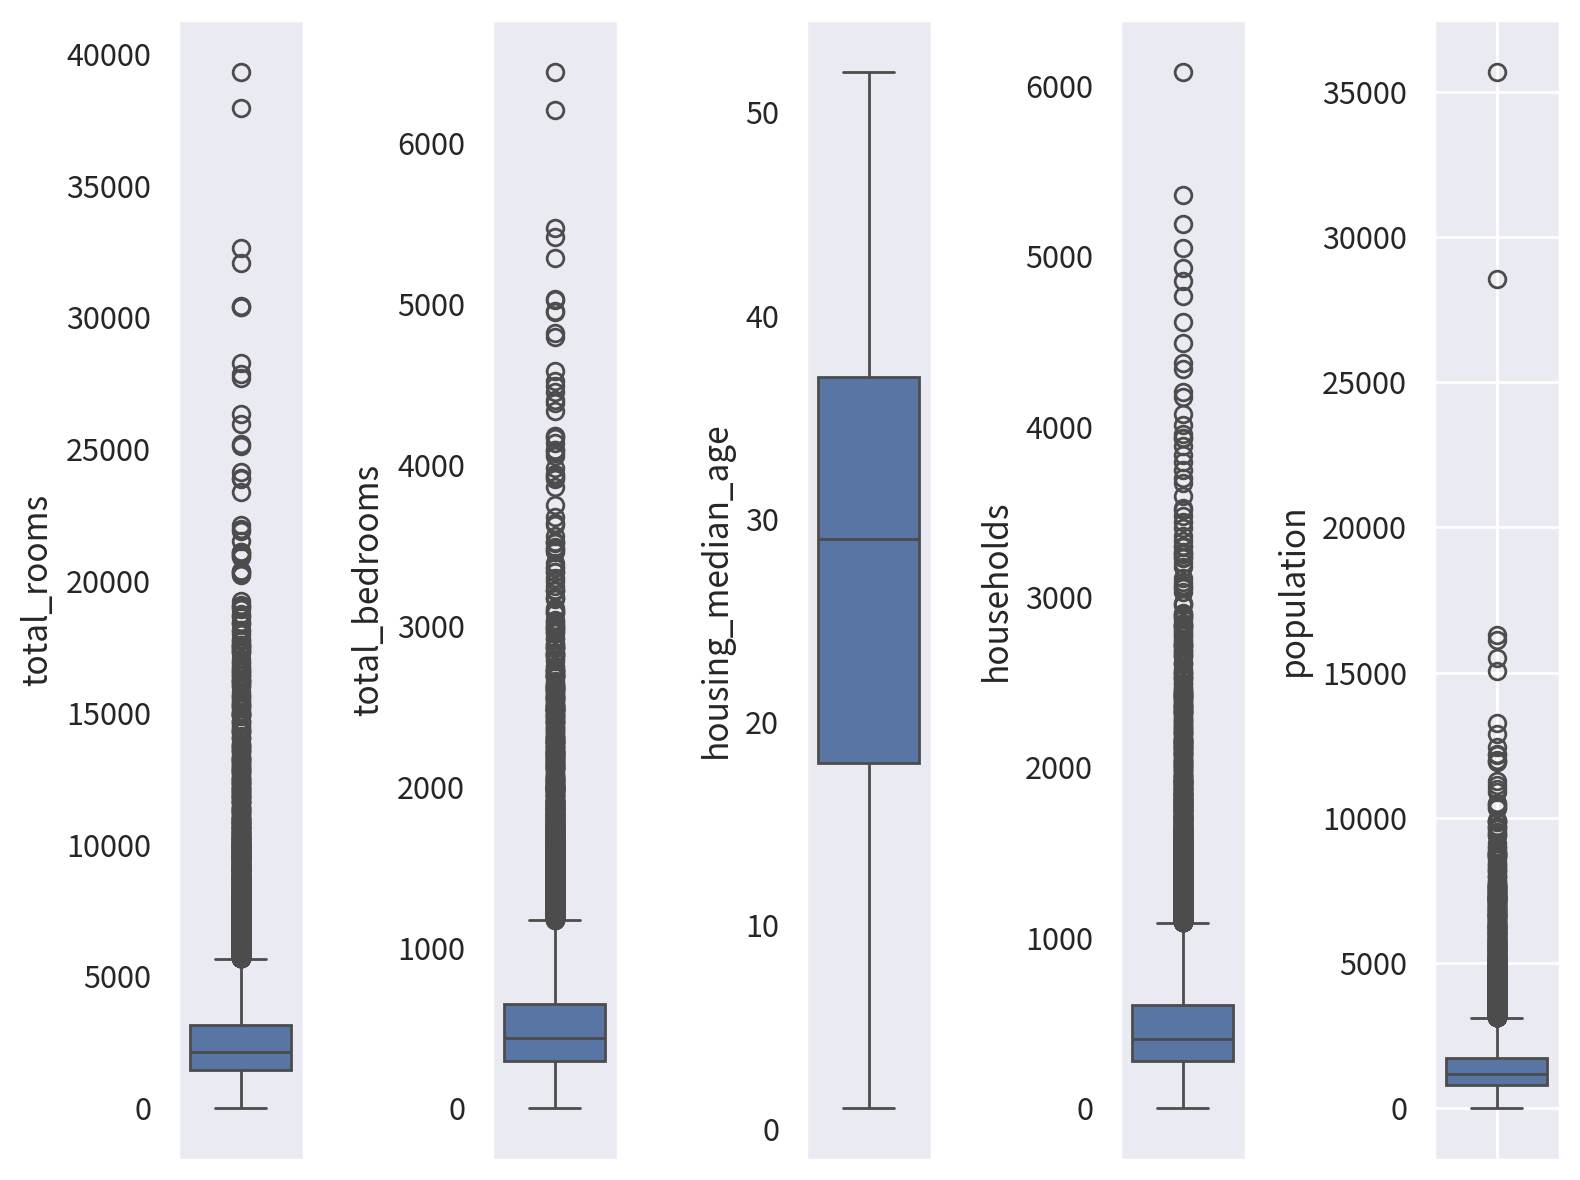

In [22]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600             #그래프 가로 크기
height_px = 1200             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 5                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df2['total_rooms'],orient='v',ax=ax[0])
sb.boxplot(data=df2['total_bedrooms'],orient='v',ax=ax[1])
sb.boxplot(data=df2['housing_median_age'],orient='v',ax=ax[2])
sb.boxplot(data=df2['households'],orient='v',ax=ax[3])
sb.boxplot(data=df2['population'],orient='v',ax=ax[4])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 데이터의 분포가 극단적이라 로그 변환을 했었음
- total_rooms는 0~5682.5 | total_bedrooms : 0 ~ 1173.5
- population : 0 ~ 3124.5 | households : 0 ~ 1090.0

- housing_median_age : 0 ~ 65.5 

- 상식선으로 총 방 개수가 4만개면 가구수가 6000개 있는 지역이라 했을 때 6000개 모두 방이 7개 가량 있다는 뜻
    - kaggle 데이터 셋인 California housing의 AveRooms를 참고하면 평균 방 수가 7개 이상인 데이터 건수가 꽤 되는 것 같아서 현실성 있다고 판단.
    - 4~5개가 평균인 듯 하며, 안정범위인 5682.5는 저소득 구간의 주택에 방 개수로 측정 된 것.
    - 고가의 주택 방 개수가 많기 때문에 이상치가 많이 찍힘
    - 이는 빈부격차로 인한 데이터 분포의 비대칭성이 일어난 것.
    - 이상치로 여기지 않고 충분히 있을 수 있는 조건이라고 생각하고 별도의 전처리 X
        - 로그 변환한 값도 가지고 있기 때문에 둘 다 모델을 돌려보고 성능 비교 (AUC)


In [23]:
# 데이터의 정상 범위 출력하기
data_columns = ['total_rooms', 'total_bedrooms', 'housing_median_age', 'households', 'population']
Q1 = df2[data_columns].quantile(0.25)
Q3 = df2[data_columns].quantile(0.75)
IQR = Q3 - Q1

for i in data_columns:
    # lower_bound가 음수가 될 수 있으므로 음수면 0으로 처리
    lower_bound = max(0, Q1[i] - 1.5 * IQR[i])  #max함수로 0과 비교했을 때 0이 더 크면 0이 나옴
    upper_bound = Q3[i] + 1.5 * IQR[i]
    print(f"{i}의 정상 범위: {lower_bound} ~ {upper_bound}")

total_rooms의 정상 범위: 0 ~ 5682.5
total_bedrooms의 정상 범위: 0 ~ 1173.5
housing_median_age의 정상 범위: 0 ~ 65.5
households의 정상 범위: 0 ~ 1090.0
population의 정상 범위: 0 ~ 3124.5


### 미션 7. 소득과 다른 특성은 독립적일까?
- 주요 연속형 변수 간 상관행렬(median_income, housing_median_age, total_rooms, total_bedrooms, population, households,위도,경도)을 계산한다.
- 상관행렬을 히트맵으로 시각화하고, Variance Inflation Factor(VIF)로 다중공선성을 점검한다.
- 높은 상관이 보이는 변수 쌍(예: total_rooms vs total_bedrooms)에 대해, 이것이 모델 설계에 주는 함의를 논의하세요.
- 공선성 완화 전략을 고민하세요 : 변수 제거, 결합지표 설계 등 "해석 우선" 관점에서 선택합니다.

In [24]:
skew_outlier={}
for col in df2.columns:
    temp = df2[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col]= {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }
skew_outlier_df=DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z| > 3)
longitude,-0.296141,-0.615021,0.0
latitude,0.464934,0.080448,0.0
housing_median_age,0.061605,-1.140460,0.0
total_rooms,4.158816,-1.103204,371.0
total_bedrooms,3.459546,-0.992813,370.0
population,4.960017,-1.105859,339.0
households,3.413850,-1.056801,362.0
median_income,1.644557,0.336080,340.0
median_house_value,0.978290,-1.297926,0.0


In [25]:
rows = []

for a, b in combinations(df2.columns,2):
    x = df2[a]
    y = df2[b]

    # [1] 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue>0.05

    # [2] 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] >0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] >0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x,y)
    else:
        chosen = 'spearman'
        corr,pval = spearmanr(x,y)

    # [4] 유의성 판단(p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # [6] 행 추가
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,longitude,latitude,False,False,spearman,-0.878908,0.000000e+00,True,Very strong
1,longitude,housing_median_age,False,False,spearman,-0.151840,1.205253e-105,True,Very weak
2,longitude,total_rooms,False,True,spearman,0.041203,3.817272e-09,True,Very weak
3,longitude,total_bedrooms,False,True,spearman,0.063879,6.248559e-20,True,Very weak
4,longitude,population,True,True,spearman,0.124223,4.523354e-71,True,Very weak
5,longitude,households,False,True,spearman,0.060889,3.005110e-18,True,Very weak
6,longitude,median_income,False,True,spearman,-0.010225,1.438699e-01,False,Very weak
7,longitude,median_house_value,False,False,spearman,-0.069679,2.026131e-23,True,Very weak
8,latitude,housing_median_age,False,False,spearman,0.032984,2.406680e-06,True,Very weak
9,latitude,total_rooms,True,True,spearman,-0.019288,5.829420e-03,True,Very weak


- total_rooms : total_bedrooms, population, households와 강한 상관관계
- total_bedrooms : population, households와 강한 상관관계
- population : households와 강한 상관관계
- median_income : median_house_value와 강한 상관관계를 이룸

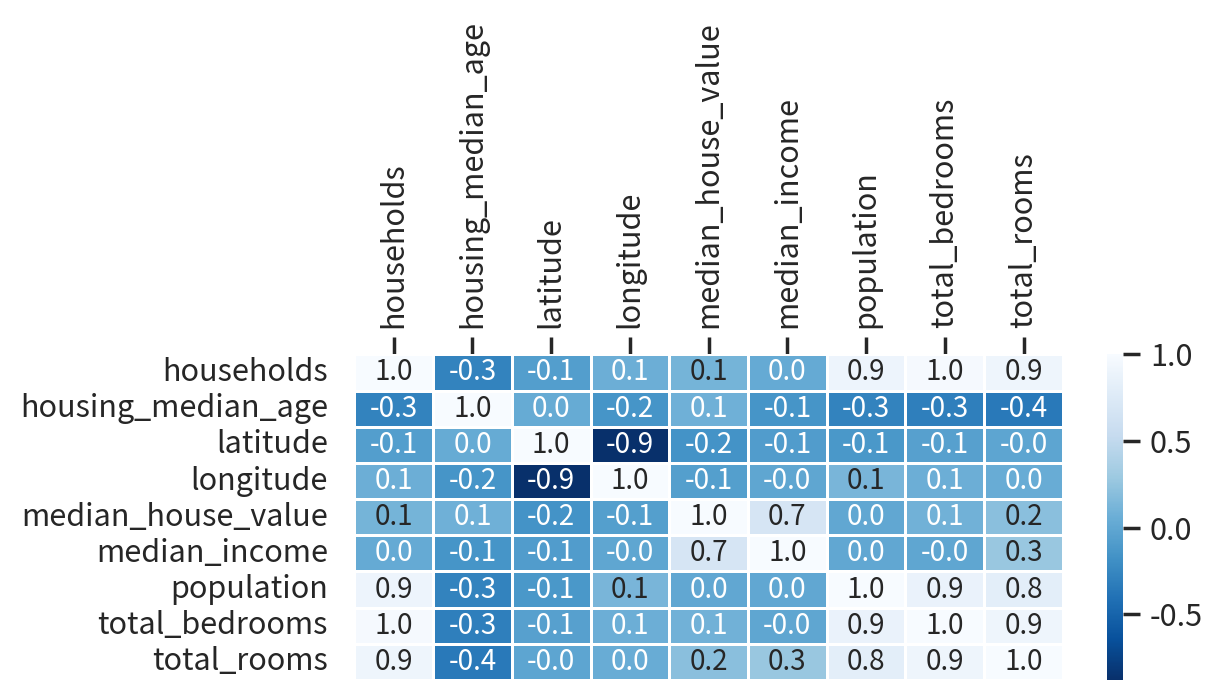

In [26]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r # 대칭

# 4) 대각선 (diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

# corr_matrix
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':10})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()
plt.close()


- 위경도는 실제 데이터를 사용해야하므로 무시
- households, population, total_bedrooms, total_rooms는 따로 처리할 필요가 있음
    - households(가구 수)가 많으면 당연하게도 total_rooms와 total_bedrooms가 많아지고 가구 수가 많고 방 수도 많으면 population(구성원 수)도 많아지기 때문
    - vif가 높은 순서대로 하나씩 제거하며 진행

In [27]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary()의 결과로 생성된 summary 객체
    data : pandas.DataFrame
    종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    #독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != 'const']

    #독립변수 부분 데이터(VIF 계산용)
    indi_df = data.filter(xnames)

    #독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        #한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        #VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df.values, j)

        #유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p:(
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        #한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B": v[1].strip(),
            "표준오차": v[2].strip(),
            "Beta": float(fit.params[name]) * data[name].std() / data[yname].std(ddof=1),
            "t": "%s%s" %(v[3].strip(), stars(p)),
            "p-value": p,
            "공차" : 1/vif,
            "vif": vif
        })
    rdf = DataFrame(variables)

    #summary 표에서 적합도 정보를 key-value로 추출

    result_dict={}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0,n,2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue

                result_dict[key]=value

    #적합도 보고 문자열 생성
    result_report = f"R({result_dict['R-squared']}), R^2({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}, p={result_dict['Prob (F-statistic)']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})" 

    #모형 보고 문자열 생성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl %(
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다" if float(result_dict['Prob (F-statistic)']) <= 0.05 else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<=" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    #변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s %(row['독립변수'],
            row['B'],
            "<=" if float(row['p-value']) < 0.05 else ">",
            row['종속변수'],
            "유의한" if float(row['p-value']) < 0.05 else "유의하지 않은"))
    return rdf, result_report, model_report, variable_reports


In [28]:
df3 = df2.copy()
yname = 'median_house_value'

x=df3.drop([yname,'latitude','longitude'], axis=1)
y=df3[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     4453.
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        10:29:01   Log-Likelihood:            -2.5862e+05
No. Observations:               20433   AIC:                         5.173e+05
Df Residuals:                   20426   BIC:                         5.173e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.614e+04   2252

In [29]:
rdf,r,m,v = ols_report(tbl1, df3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,1882.1214,45.522,0.205303,41.346***,0.0,0.278988,3.584386
1,median_house_value,total_rooms,-19.7331,0.839,-0.373560,-23.509***,0.0,0.036542,27.366089
2,median_house_value,total_bedrooms,100.9438,7.518,0.368484,13.428***,0.0,0.011545,86.616753
3,median_house_value,population,-35.3190,1.170,-0.346720,-30.175***,0.0,0.064181,15.580855
4,median_house_value,households,124.8032,8.086,0.413322,15.434***,0.0,0.011057,90.439831
5,median_house_value,median_income,4.775e+04,344.284,0.785616,138.689***,0.0,0.208300,4.800762


median_house_value에 대하여 housing_median_age,total_rooms,total_bedrooms,population,households,median_income로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,20426) = 4453., p <= 0.05).


total_bedrooms 탈락

In [30]:
df4 = df3.drop('total_bedrooms', axis=1)
yname = 'median_house_value'

x=df4.drop([yname,'latitude','longitude'], axis=1)
y=df4[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df4)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,1842.7934,45.626,0.201013,40.389***,0.0,0.288826,3.462295
1,median_house_value,total_rooms,-13.9705,0.725,-0.264469,-19.282***,0.0,0.047233,21.171700
2,median_house_value,population,-39.3121,1.137,-0.385918,-34.574***,0.0,0.067401,14.836513
3,median_house_value,households,214.0020,4.631,0.708731,46.210***,0.0,0.035065,28.518266
4,median_house_value,median_income,4.6e+04,320.214,0.756906,143.665***,0.0,0.225892,4.426901


median_house_value에 대하여 housing_median_age,total_rooms,population,households,median_income로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,20427) = 5262., p <= 0.05).


households 탈락

In [31]:
df5 = df4.drop('households', axis=1)
yname = 'median_house_value'

x=df5.drop([yname,'latitude','longitude'], axis=1)
y=df5[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df5)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,1980.4742,47.848,0.216032,41.391***,0.0,0.319681,3.128121
1,median_house_value,total_rooms,9.2805,0.548,0.175685,16.938***,0.0,0.089459,11.178245
2,median_house_value,population,-11.7624,1.018,-0.115469,-11.560***,0.0,0.098659,10.135893
3,median_house_value,median_income,4.131e+04,319.171,0.679730,129.438***,0.0,0.240835,4.152223


median_house_value에 대하여 housing_median_age,total_rooms,population,median_income로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,20428) = 5471., p <= 0.05).


total_rooms 탈락

In [32]:
df6 = df5.drop('total_rooms', axis=1)
yname = 'median_house_value'

x=df6.drop([yname,'latitude','longitude'], axis=1)
y=df6[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df6)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,1829.1452,47.335,0.199524,38.643***,0.0,0.346421,2.886659
1,median_house_value,population,3.0658,0.522,0.030096,5.870***,0.0,0.487109,2.052928
2,median_house_value,median_income,4.326e+04,299.778,0.711802,144.314***,0.0,0.297418,3.362268


median_house_value에 대하여 housing_median_age,population,median_income로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,20429) = 7100., p <= 0.05).


- 남은 변수..housing_median_age, population, median_income
- 변수 제거 방식으로 공선성 완화를 해봤는데, 남은 변수가 집 나이, 가구수, 중위 소득수 임.. 주택 가격 형성 구조를 정하기엔 고려해야 할 변수들이 너무 빠진 느낌
- 다른 방식으로는 VIF 값이 높았던 변수들로 파생 변수를 만들어서 해보는 방법 정도?

### 미션 8. 어떤 변수가 가격과 가장 가까울까?
- median_house_value와 연속형 변수들의 상관을 계산한다.
- Pearson과 Spearman을 모두 계산하고, 비교해 무엇이 더 적합한지 이유를 적으세요.
- 각 변수의 관계를 물리,사회적 언어로 해석하고(예: 소득이 높을수록 비싼 주택 지역, 오래된 주택은 더 저렴), 인과성을 말할 수 있는지 비판적으로 평가합니다.

In [33]:
#median_house_value와 연속형 변수들간의 상관 계산
for col in df2.columns:
    if col == 'median_house_value':
        continue

    x = df2[col]
    y = df2['median_house_value']

    spearman_r, spearman_p = spearmanr(x,y)
    print(f"{col}와 median_house_value의 스피어만 상관계수: {spearman_r:.3f}, p-value: {spearman_p:.3f}, {'대립' if spearman_p <= 0.05 else '귀무'}가설 채택")

longitude와 median_house_value의 스피어만 상관계수: -0.070, p-value: 0.000, 대립가설 채택
latitude와 median_house_value의 스피어만 상관계수: -0.166, p-value: 0.000, 대립가설 채택
housing_median_age와 median_house_value의 스피어만 상관계수: 0.075, p-value: 0.000, 대립가설 채택
total_rooms와 median_house_value의 스피어만 상관계수: 0.205, p-value: 0.000, 대립가설 채택
total_bedrooms와 median_house_value의 스피어만 상관계수: 0.086, p-value: 0.000, 대립가설 채택
population와 median_house_value의 스피어만 상관계수: 0.003, p-value: 0.681, 귀무가설 채택
households와 median_house_value의 스피어만 상관계수: 0.112, p-value: 0.000, 대립가설 채택
median_income와 median_house_value의 스피어만 상관계수: 0.677, p-value: 0.000, 대립가설 채택


- 미션 7을 진행하면서 나온 결과를 통해 스피어만 상관계수 사용
    - 대부분의 데이터가 선형성을 위배하기 때문에 스피어만이 채택됨
- 변수 하나씩 해석
    - 경도(longitude)와 위도(latitude)는 음의 상관관계를 보임 -> 위도와 경도가 낮아질수록 (남쪽일수록) 집값이 비싼 경향이 있음
    - 중위 집 나이(housing_median_age)의 경우 양의 상관관계를 보임 -> 나이가 많아질수록 집값이 비싸진다고 볼 수 있지만 매우 약한 관계이므로 실제로는 의미 없는 수치라고 할 수 있음.
        - 보통 새 집이 비싼것이 맞지만 캘리포니아 지역 특성상 오래된 집이 비싼 동네에 많을뿐이지 오래된 집이 비싼 것은 아닐듯. 서울로 비유해서 생각해도 비슷함.
    - 방의 개수(total_rooms)는 양의 상관관계로 많을수록 집 값이 비싸지는 경향이 있음. 
    - 침실의 개수(total_bedrooms) 또한 양의 상관관계지만 약한 상관관계임
    - 인구 수(population)는 계수가 0.003으로 매우 약한 양의 상관관계를 가지고 있음. -> 인구수 자체의 변수보다는 가구당 인구 밀도 혹은 소득이 집값에 더 영향이 크다는 것을 유추해볼 수 있음.
    - 가구 수(households)는 0.112로 약한 양의 상관관계를 가지고 있음. 인구수와 가구수는 비슷한 의미로 결국 숫자가 늘어나면 집 값이 오르는 경향은 있지만 그 효과가 매우 미미하다고 볼 수 있음.
    - 중위 소득(median_income)은 0.677로 강한 양의 상관관계가 있음을 알 수 있음. -> 중위 소득이 높을수록 집 값이 비싸짐 
- 캘리포니아의 주택 가격은 인구 밀집과는 거리가 멀고 중위 소득과 위치와의 거리가 가깝다고 볼 수 있음.

### 미션 9. 상관관계는 곧 원인일까?
- 상관이 높다 != 원인이다
- 예: 위도/경도와 주택가격의 높은 상관이 정말 위치 자체가 가격을 결정하는가, 아니면 위치가 소득 수준이 높은 지역을 나타내는 대리 변수인가?
- 데이터 수집 시점(1990년), 지역 편향, 측정 누락(학군 질, 교통 접근성, 범죄율 등)이 결론에 주는 한계를 서술하세요.

- 소득이 집값과 강한 상관관계를 보인것은 사실임. 계수가 0.677이라고는 하지만, 소득만이 집값을 결정하는 것은 아님. 소득이 높기 때문에 집값이 높아야만해!! 는 아닌 것을 알아야 하고, 위도와 경도 역시 그 자체로 집 값이 정해지는 것이 아니라 고소득층이 해당 위도 경도에 밀집해있다는 뜻으로 받아들여야함.
- 데이터 수집 시점인 1990년은 분석 시점인 현재(2025년)와는 35년이라는 시간 간극이 존재함. 이는 현 시장에 반영하기엔 노후된 데이터라고 생각이 됨. 또한, 집 값을 결정하는 요인이라고 하기엔 학군 질, 교통 접근성, 범죄율 등 고려해야하는 요인이 수없이도 많음. 빠진 데이터가 많을 뿐더러 캘리포니아만의 데이터이기 때문에 **1990년대의 캘리포니아 집값을 결정했던 요인** 이라고 했을 때만 유의미한 데이터 분석이라고 볼 수 있음.

### 미션 10. 주택 가격을 설명하는 회귀모형 설계
- median_house_value(또는 변환값)를 종속변수로 하는 다중선형회귀(OLS)를 설계한다.
- 변수 선택,스케일/변환 이유를 설명하고 싶어서 관점으로 글로 남긴다.
- statsmodels의 OLS를 사용하여 회귀모형을 적합하고, 모형 요약(summary)을 통해 계수, p-value, 신뢰구간을 확인한다.
- 적합도 지표를 확인한다: R^2/Adj. R^2, RMSE/MAE를 계산하고 1990년 주택 가격 맥락에서 해석한다.
- 공선성은 상관행렬,VIF로 점검하고, 필요 시 변수 제거,결합지표로 완화한다.

잔차 검정
- 선형성 검정 (RESET 테스트 통계량 확인)

In [34]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 220.8024
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


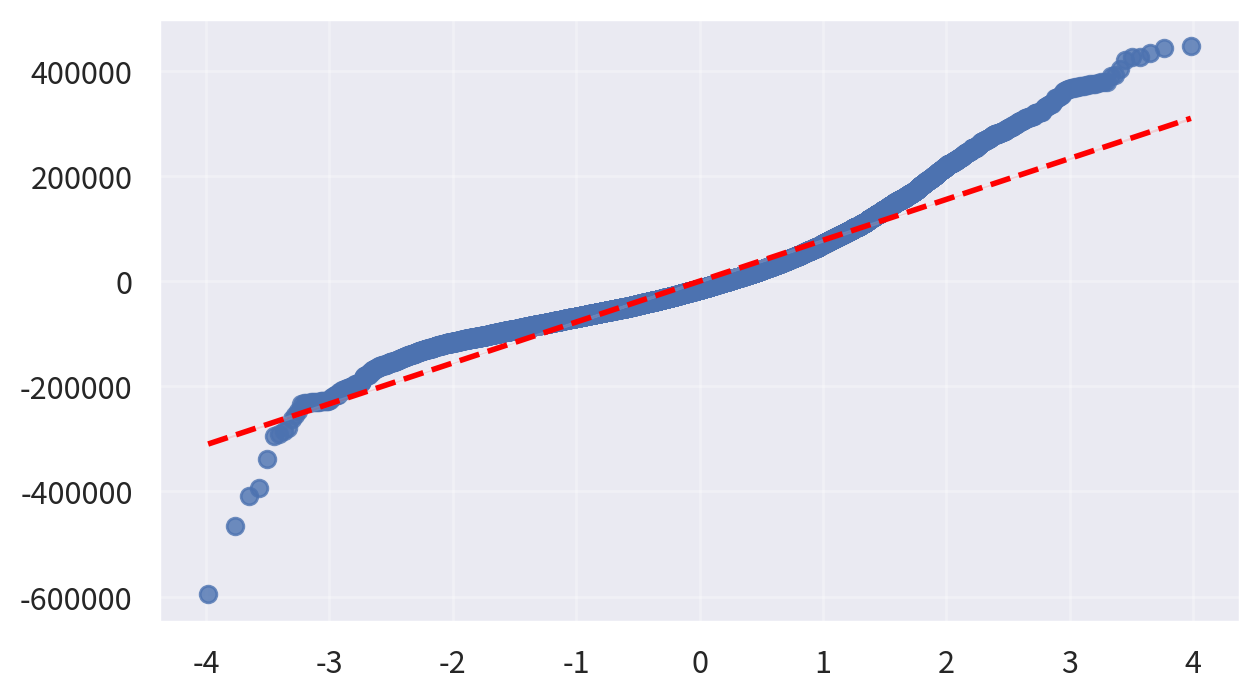

In [35]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [36]:
# 성능 향상을 위한 종속변수 로그 변환
df7 = df6.copy()
df7['median_house_value'] = np.log1p(df6['median_house_value'])
yname = 'median_house_value'
x=df7.drop([yname,'latitude','longitude'], axis=1)
y=df7[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf,r,m,v = ols_report(tbl1, df7)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,0.0079,0.000,0.175327,32.385***,0.0,0.346421,2.886659
1,median_house_value,population,3.131e-05,2.7e-06,0.062338,11.596***,0.0,0.487109,2.052928
2,median_house_value,median_income,0.2036,0.002,0.679233,131.337***,0.0,0.297418,3.362268


median_house_value에 대하여 housing_median_age,population,median_income로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,20429) = 5842., p <= 0.05).


In [37]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 1585.4683
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


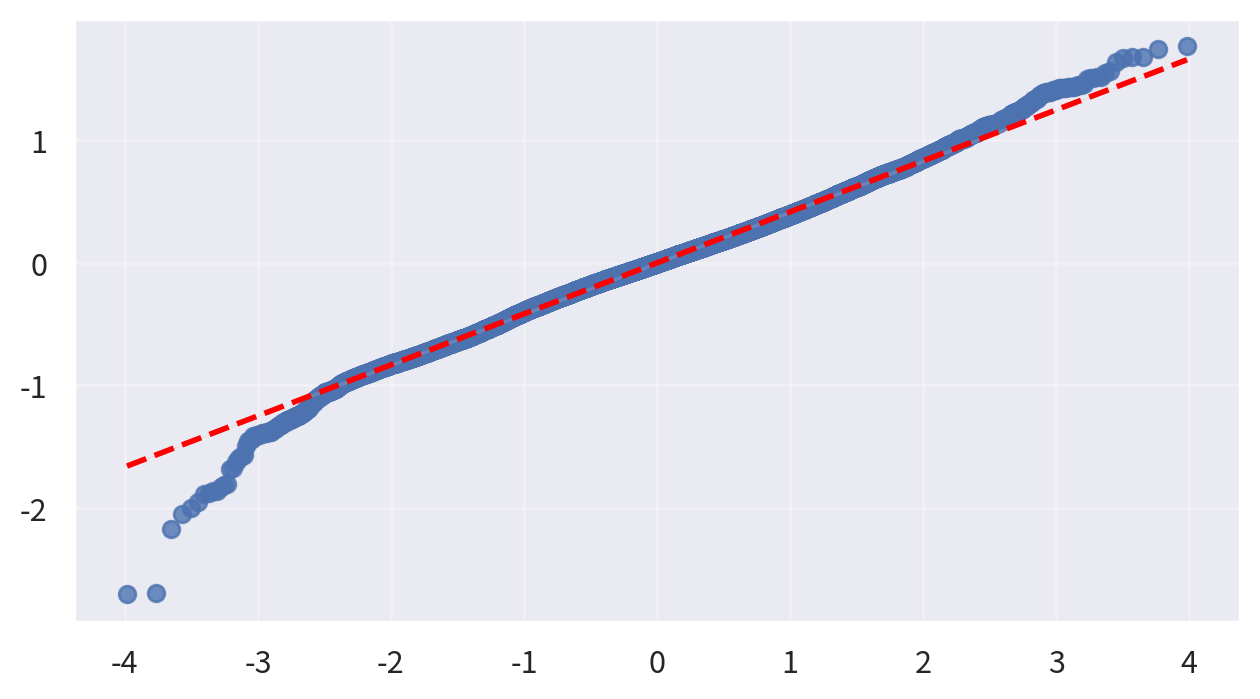

In [38]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

- 집 가격 데이터에 500,001 에 해당하는 고가의 데이터들 때문에 Q-Q 플롯의 오른쪽 끝이 솟구침
    - 해결하기 위해 로그 변환

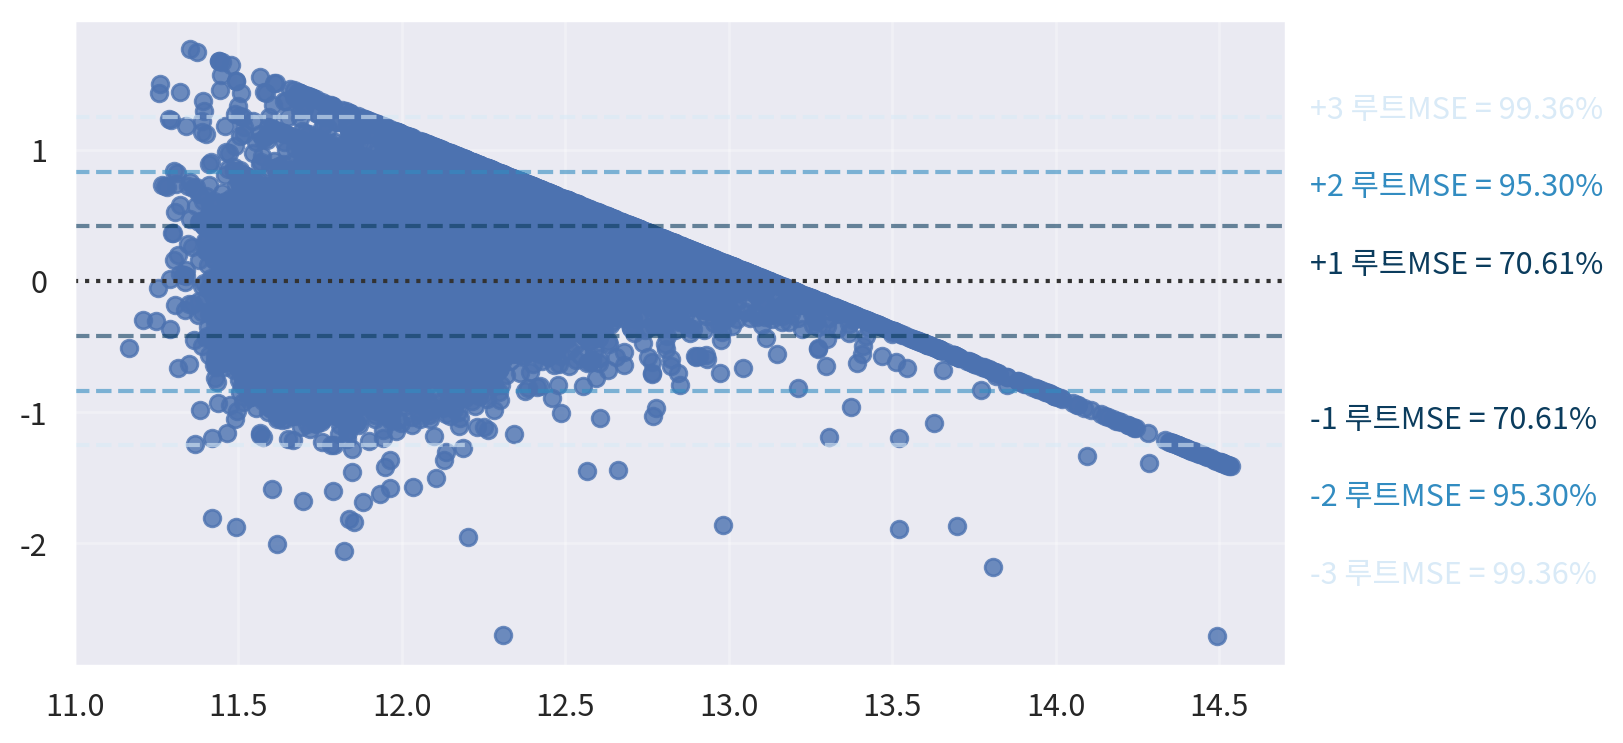

In [39]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid       #잔차

r1 = r[(r>-mse_root) & (r<mse_root)].count() / r.count() * 100
r2 = r[(r>-2*mse_root) & (r<2*mse_root)].count() / r.count() * 100
r3 = r[(r>-3*mse_root) & (r<3*mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0b3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, dpi=my_dpi, figsize=figsize, constrained_layout=True)

sb.residplot(x=fit.fittedvalues, y=fit.resid)

ax.grid(True, alpha=0.3)

for i, c in enumerate(colors):
    k= i + 1

    y_pos = k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    
    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()

r1이 70.61%, r2가 95.30%로 정상 범위라고 할 수 있음

In [42]:
m

'median_house_value에 대하여 housing_median_age,population,median_income로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,20429) = 5842., p <= 0.05).'

In [43]:
print("\n".join(v))

housing_median_age의 회귀계수는 0.0079(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
population의 회귀계수는 3.131e-05(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
median_income의 회귀계수는 0.2036(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.


- 소득은 주택 가격의 핵심 요인으로 결정됨
- 집의 나이가 많아질수록 가격이 미세하게 오르지만, 집의 나이에 초점을 맞출 것이 아니라 해당 입지가 좋은 것이라고 생각됨. 지리적 위치를 분석해볼 필요가 있음.
- 인구수는 매우 작은 계수로 통계적으로는 유의미하지만 영향은 거의 없음.

잊고 있었던 ocean_proximity를 이용하여 지리적 위치에 따른 요인도 포함하여 계산해보기

In [49]:
df = df.astype({'ocean_proximity':'category'})
df8 = df.copy()
df8['median_house_value'] = np.log1p(df8['median_house_value'])
# 더미변수를 bool이 아닌 int형으로 변환
df8_dummies = pd.get_dummies(df8, columns=['ocean_proximity'], drop_first=True, dtype=int)
# df8_dummies.info()
yname = 'median_house_value'
x=df8_dummies.drop([yname,'latitude','longitude'], axis=1)
y=df8_dummies[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf,r,m,v = ols_report(tbl1, df8_dummies)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,0.0032,0.000,0.070568,14.835***,0.000,0.239189,4.180796
1,median_house_value,total_rooms,-2.278e-05,3.88e-06,-0.087442,-5.871***,0.000,0.035995,27.781468
2,median_house_value,total_bedrooms,0.0003,3.35e-05,0.204557,8.248***,0.000,0.011386,87.825016
3,median_house_value,population,-0.0002,5.27e-06,-0.329515,-31.411***,0.000,0.062793,15.925228
4,median_house_value,households,0.0004,3.62e-05,0.274936,11.297***,0.000,0.010784,92.728130
5,median_house_value,median_income,0.1765,0.002,0.588904,107.136***,0.000,0.206354,4.846037
6,median_house_value,ocean_proximity_INLAND,-0.4886,0.006,-0.399744,-80.206***,0.000,0.662543,1.509335
7,median_house_value,ocean_proximity_ISLAND,0.7218,0.151,0.019834,4.770***,0.000,0.998384,1.001619
8,median_house_value,ocean_proximity_NEAR BAY,0.0008,0.008,0.000449,0.099,0.921,0.748019,1.336864
9,median_house_value,ocean_proximity_NEAR OCEAN,0.0203,0.008,0.011921,2.689**,0.007,0.795074,1.257745


median_house_value에 대하여 housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(10,20422) = 3749., p <= 0.05).


In [50]:
# vif 가장 높은 변수 제거
df9 = df8_dummies.drop('households', axis=1)
yname = 'median_house_value'
x=df9.drop([yname,'latitude','longitude'], axis=1)
y=df9[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf,r,m,v = ols_report(tbl1, df9)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,0.0033,0.000,0.073055,15.327***,0.000,0.239376,4.177520
1,median_house_value,total_rooms,-2.506e-05,3.89e-06,-0.096214,-6.449***,0.000,0.036058,27.733114
2,median_house_value,total_bedrooms,0.0006,1.97e-05,0.431828,29.682***,0.000,0.036334,27.522204
3,median_house_value,population,-0.0001,4.6e-06,-0.271283,-29.601***,0.000,0.082950,12.055427
4,median_house_value,median_income,0.1782,0.002,0.594742,108.345***,0.000,0.208170,4.803765
5,median_house_value,ocean_proximity_INLAND,-0.4946,0.006,-0.404650,-81.248***,0.000,0.673377,1.485053
6,median_house_value,ocean_proximity_ISLAND,0.6855,0.152,0.018837,4.517***,0.000,0.998843,1.001158
7,median_house_value,ocean_proximity_NEAR BAY,0.0057,0.008,0.003159,0.696,0.486,0.750062,1.333223
8,median_house_value,ocean_proximity_NEAR OCEAN,0.0213,0.008,0.012502,2.812**,0.005,0.795090,1.257720


median_house_value에 대하여 housing_median_age,total_rooms,total_bedrooms,population,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(9,20423) = 4126., p <= 0.05).


In [51]:
# total_bedrooms 제거
df10 = df9.drop('total_bedrooms', axis=1)
yname = 'median_house_value'
x=df10.drop([yname,'latitude','longitude'], axis=1)
y=df10[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf,r,m,v = ols_report(tbl1, df10)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,0.0030,0.000,0.065930,13.561***,0.000,0.265807,3.762131
1,median_house_value,total_rooms,6.641e-05,2.42e-06,0.254964,27.464***,0.000,0.086218,11.598538
2,median_house_value,population,-9.815e-05,4.51e-06,-0.195394,-21.738***,0.000,0.097135,10.294928
3,median_house_value,median_income,0.1538,0.001,0.513170,105.740***,0.000,0.239389,4.177296
4,median_house_value,ocean_proximity_INLAND,-0.5324,0.006,-0.435533,-87.556***,0.000,0.673425,1.484946
5,median_house_value,ocean_proximity_ISLAND,0.7085,0.155,0.019470,4.571***,0.000,0.998910,1.001091
6,median_house_value,ocean_proximity_NEAR BAY,0.0118,0.008,0.006526,1.408,0.159,0.750969,1.331613
7,median_house_value,ocean_proximity_NEAR OCEAN,0.0210,0.008,0.012365,2.723**,0.006,0.799966,1.250053


median_house_value에 대하여 housing_median_age,total_rooms,population,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(8,20424) = 4345., p <= 0.05).


In [52]:
# total_rooms 제거
df11 = df10.drop('total_rooms', axis=1)
yname = 'median_house_value'
x=df11.drop([yname,'latitude','longitude'], axis=1)
y=df11[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
rdf,r,m,v = ols_report(tbl1, df11)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,0.0020,0.000,0.044633,9.132***,0.0,0.296739,3.369963
1,median_house_value,population,9.263e-06,2.3e-06,0.018440,4.032***,0.0,0.468995,2.132220
2,median_house_value,median_income,0.1693,0.001,0.564732,123.925***,0.0,0.292766,3.415692
3,median_house_value,ocean_proximity_INLAND,-0.5016,0.006,-0.410395,-82.430***,0.0,0.692348,1.444361
4,median_house_value,ocean_proximity_ISLAND,0.7656,0.158,0.021037,4.851***,0.0,0.999071,1.000930
5,median_house_value,ocean_proximity_NEAR BAY,0.0430,0.008,0.023717,5.073***,0.0,0.764502,1.308042
6,median_house_value,ocean_proximity_NEAR OCEAN,0.0394,0.008,0.023148,5.025***,0.0,0.804031,1.243733


median_house_value에 대하여 housing_median_age,population,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(7,20425) = 4685., p <= 0.05).


In [53]:
#median_house_value와 연속형 변수들간의 상관 계산
for col in df11.columns:
    if col == 'median_house_value':
        continue

    x = df11[col]
    y = df11['median_house_value']

    spearman_r, spearman_p = spearmanr(x,y)
    print(f"{col}와 median_house_value의 스피어만 상관계수: {spearman_r:.3f}, p-value: {spearman_p:.3f}, {'대립' if spearman_p <= 0.05 else '귀무'}가설 채택")

longitude와 median_house_value의 스피어만 상관계수: -0.070, p-value: 0.000, 대립가설 채택
latitude와 median_house_value의 스피어만 상관계수: -0.166, p-value: 0.000, 대립가설 채택
housing_median_age와 median_house_value의 스피어만 상관계수: 0.075, p-value: 0.000, 대립가설 채택
population와 median_house_value의 스피어만 상관계수: 0.003, p-value: 0.681, 귀무가설 채택
median_income와 median_house_value의 스피어만 상관계수: 0.677, p-value: 0.000, 대립가설 채택
ocean_proximity_INLAND와 median_house_value의 스피어만 상관계수: -0.566, p-value: 0.000, 대립가설 채택
ocean_proximity_ISLAND와 median_house_value의 스피어만 상관계수: 0.021, p-value: 0.003, 대립가설 채택
ocean_proximity_NEAR BAY와 median_house_value의 스피어만 상관계수: 0.160, p-value: 0.000, 대립가설 채택
ocean_proximity_NEAR OCEAN와 median_house_value의 스피어만 상관계수: 0.141, p-value: 0.000, 대립가설 채택


- 지리적 위치를 나타내는 더미 변수를 추가해도 여전히 소득(median_income)이 가장 높은 상관계수를 가짐
    - 소득이 높을수록 집값도 높을 가능성이 매우 크다!
- 지리적 위치로는 내륙(INLAND)이 -0.566으로 내륙으로 갈 수록 집 값이 낮아질 가능성이 크다!
    - 이는 캘리포니아의 위치 특성상 내륙보다는 바닷가쪽에 샌프란시스코와 로스앤젤레스, 샌디에고, 산호세 등 주요 도시가 있기 때문에 나타나는 현상으로 유추됨

In [54]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 1637.0177
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


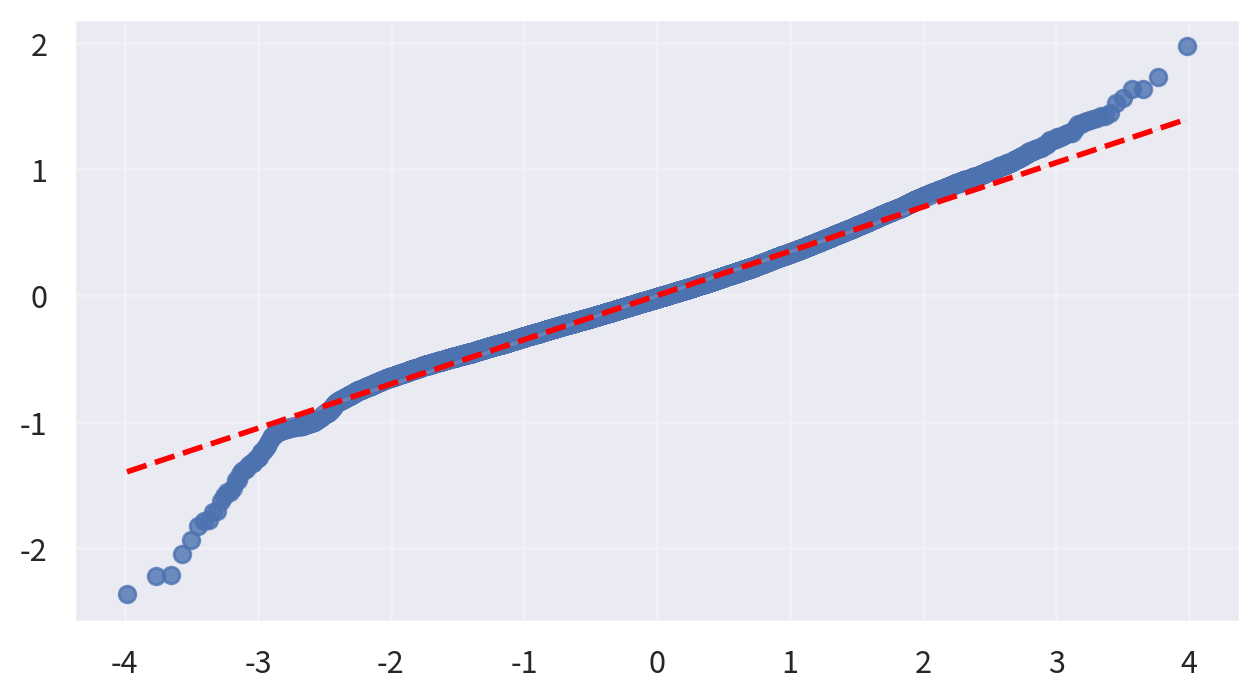

In [55]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

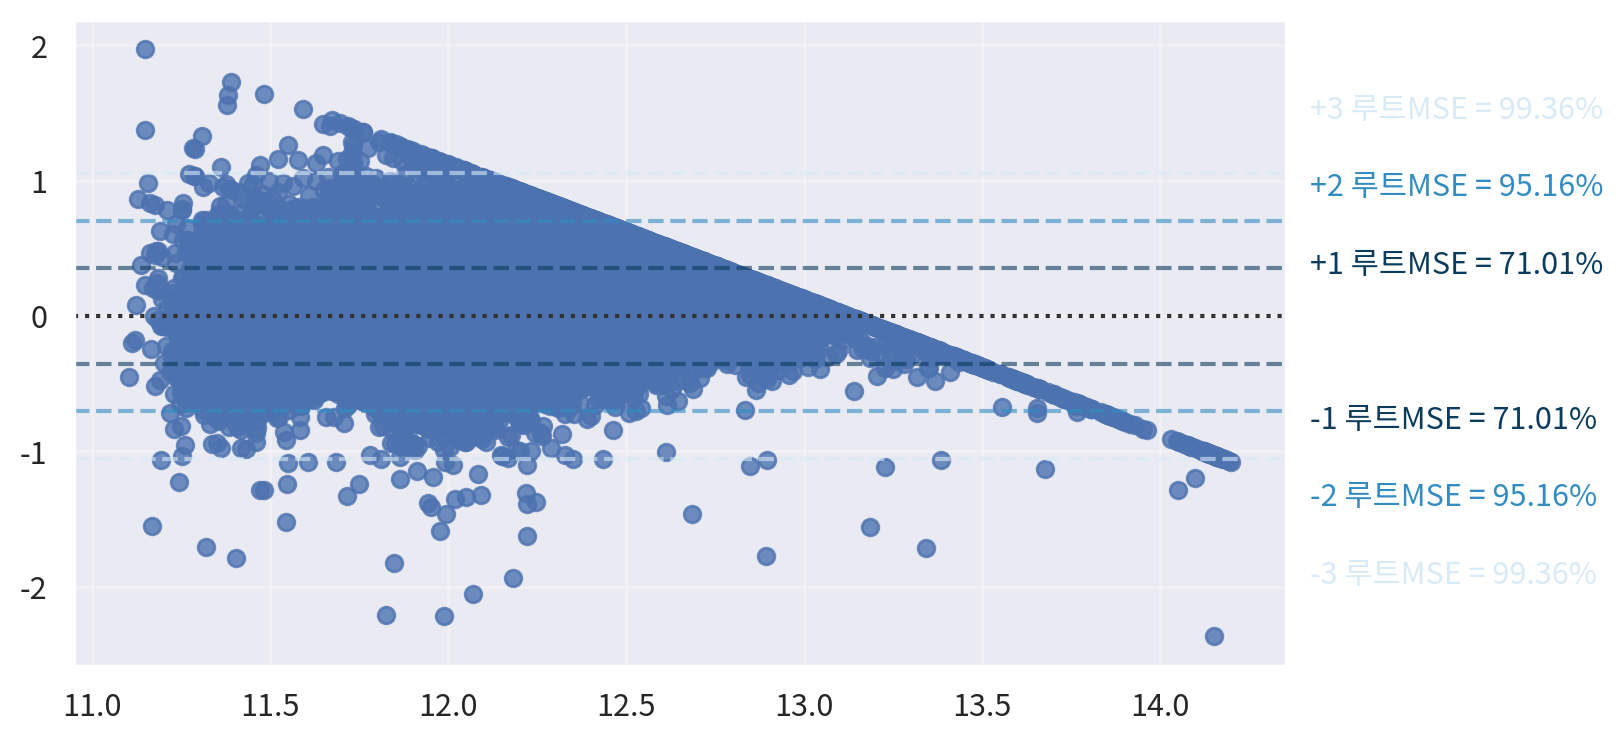

In [56]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid       #잔차

r1 = r[(r>-mse_root) & (r<mse_root)].count() / r.count() * 100
r2 = r[(r>-2*mse_root) & (r<2*mse_root)].count() / r.count() * 100
r3 = r[(r>-3*mse_root) & (r<3*mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0b3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, dpi=my_dpi, figsize=figsize, constrained_layout=True)

sb.residplot(x=fit.fittedvalues, y=fit.resid)

ax.grid(True, alpha=0.3)

for i, c in enumerate(colors):
    k= i + 1

    y_pos = k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    
    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()

- r1,r2 수치가 71, 95로 고르게 분포함을 의미

In [59]:
m

'median_house_value에 대하여 housing_median_age,population,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(7,20425) = 4685., p <= 0.05).'

In [60]:
print("\n".join(v))

housing_median_age의 회귀계수는 0.0020(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
population의 회귀계수는 9.263e-06(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
median_income의 회귀계수는 0.1693(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_INLAND의 회귀계수는 -0.5016(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_ISLAND의 회귀계수는 0.7656(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_NEAR BAY의 회귀계수는 0.0430(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_NEAR OCEAN의 회귀계수는 0.0394(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.


- 오.... 지역적 접근성 넣으니까 기존 연속형 변수들로만 분석한 것보다 계수가 떨어짐!!!
- ocean_proximity_ISLAND가 회귀계수 0.7656으로 가장 높게 나옴
    - 이는 ISLAND에 위치하는 집의 가격이 높을 확률이 높다라는 뜻
    - 마찬가지로 캘리포니아 주 도심지 위치 특성으로 유추됨
    - 하지만, 더미 변수들은 로그 변환이 안되어 있는 계수 값이기 때문에 다르게 해석해야함.
    - 만약, inland의 값이 -0.5016이라 해서 내륙이면 집값이 50퍼 떨어진다는게 아니라 수치를 다른 변수의 계수와 맞추어주면 실제로는 "내륙 집값은 해안가 집값의 약 0.605배 수준이다"라는 뜻으로 해석됨. -> 내륙의 경우 39.5%가 저렴하다라는 뜻

In [62]:
print(tbl1)
print(m)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     4685.
Date:                   수, 31 12 2025   Prob (F-statistic):               0.00
Time:                        10:32:14   Log-Likelihood:                -7694.9
No. Observations:               20433   AIC:                         1.541e+04
Df Residuals:                   20425   BIC:                         1.547e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

- 이리저리 중구난방으로 글을 적었기 때문에 최종 정리
    - 변수 선택,스케일/변환 이유를 설명하고 싶어서 관점으로 글로 남긴다.
        - 변수 선택은 다중공선성을 점검하고 10을 넘어가지 않는 변수들로만 구성될 때까지 삭제를 진행
        - 로그 변환을 진행한 이유는 종속 변수의 경우 선형성을 위배하는 것을 보완하고자 진행하였고, 연속형 변수의 경우 극단적으로 왼쪽으로 치우쳐져 있어 분석이 제대로 진행되지 않을 것을 방지하여 로그 변환을 진행
    - statsmodels의 OLS를 사용하여 회귀모형을 적합하고, 모형 요약(summary)을 통해 계수, p-value, 신뢰구간을 확인한다.
        - 확인 결과, p-value의 경우 모형에 들어간 변수들은 유의한 범위에 속하였고, 회귀 계수의 경우 median_income이 스피어만 회귀계수에서 가장 큰 값으로, 소득이 집값을 결정하는 중요 요인으로 보여졌으며 지리적 요인과 함께 분석을 진행했을 때는 ISLAND의 변수가 중요한 요인으로 보여졌음.
    - 적합도 지표를 확인한다: R^2/Adj. R^2, RMSE/MAE를 계산하고 1990년 주택 가격 맥락에서 해석한다.
        - 결정계수의 경우 0.616으로 1990년 당시 집값의 61.6%를 설명하고 있음. 이를 통해 소득과 위치가 가격의 핵심 요소임을 알 수 있었음.
    - 공선성은 상관행렬,VIF로 점검하고, 필요 시 변수 제거,결합지표로 완화한다.
        - 상관행렬 확인 결과 위도와 경도의 경우 실제 값을 가지고 하는 것이 더 중요하기 때문에 제외하였으며, VIF 값이 10이 넘어가지 않을 때까지 높은 순서대로 하나씩 삭제하여 최종 변수로 housing_median_age, population, median_income을 사용하였으며, 지리적 위치를 고려하기 위해 더미변수를 추가하였을 때도 위의 3가지 변수와 지리적 요인 4가지 변수를 사용하였음.

### 미션 11. 회귀계수는 무엇을 말해주나?
- 계수(또는 표준화 계수)와 신뢰구간, 방향,크기를 해석한다.
- 소득이 1만달러 늘면 주택 가격이 어떻게 바뀌는가, 주택이 1년 오래될 때마다 가격이 얼마나 떨어지는가 처럼 물리/사회적 의미로 번역한다.
- 변환 변수가 있다면, 변환을 감안한 해석을 명확히 쓴다.
- 표준화 계수(베타)와 비표준화 계수를 병행 제시하고, 단위/변환을 고려한 해석 문장을 명확히 작성합니다.
- 위도/경도 계수가 통계적으로 유의하다면, 이것이 지역의 숨은 특성을 어떻게 대리하는지 해석하세요.

- 계수(또는 표준화 계수)와 신뢰구간, 방향 크기를 해석
    - 계수는 독립변수가 종속변수에 미치는 영향의 크기와 방향을 나타낸다.

- 표준화 계수는 변수 간 영향력 비교에 유용하다.

- 방향, 즉 양수 또는 음수는 독립변수가 증가할 때 종속변수가 어떻게 변하는지를 나타낸다.

- 크기는 독립변수가 종속변수에 미치는 영향의 강도를 나타낸다.
    - 예를 들어, 표준화 계수가 0.5인 독립변수는 표준화 계수가 0.2인 독립변수보다 종속변수에 더 큰 영향을 미친다.
- 소득이 1만달러 늘면 주택 가격이 약 16.9% 상승하는 것으로 해석할 수 있다.

- 주택이 1년 오래될 때마다 가격은 약 0.2% 정도 오르는 것으로 해석할 수 있는데 이는 주택이 오래되어서 오르는 것이 아닌 해당 지역의 입지를 확인해볼 필요가 있는 것으로 파악된다.

- 변환 변수로는 더미 변수들의 회귀 계수를 해석할 때 기준 범주와 비교하여 해당 범주가 종속 변수에 미치는 영향을 이해하는 것이 중요하다.

- 로그 변환을 진행하지 않았기 때문에 그대로 해석하는 것이 아닌 백분율 변화로 해석하는 것이 더 적절하다.

- 따라서 내륙(INLAND)의 경우 -0.5016인데, 이를 계산해서 보면 exp(-0.5016) - 1 = -0.605로 약 60.5% 감소하는 것으로 해석할 수 있다.

- 표준화 계수와 비표준화 계수의 예시로는 소득(median_income) 변수를 들 수 있다.

- 비표준화 계수는 0.1693으로, 이는 소득이 1 단위 증가할 때 주택 가격이 약 0.1693 단위 증가함을 의미한다.

- 소득이 1만달러가 증가하면 주택 가격이 16.9% 상승

- 표준화 계수는 0.5762로, 이는 소득이 표준편차 단위로 1 증가할 때 주택 가격이 표준편차 단위로 약 0.5762 증가함을 의미한다.

- 이는 소득이 주택 가격에 미치는 영향력이 상당히 크다는 것을 나타내기도 한다.

- 위도/경도 계수가 통계적으로 유의하면, 특정 지역이 교육 시설, 교통 접근성, 환경적 요인 등에서 우수한 특성을 가지고 있을 시 이러한 특성들이 주택 가격에 긍정적인 영향을 미칠 수 있다.

### 미션 12. 모형 진단과 개선
- 잔차 정규성/등분산/선형성, 영향력을 점검한다.
- R^2, Adj. R^2, RMSE/MAE 등 적합도 지표를 보고하고, 1990년 명목가 기준에서 이 오차가 얼마나 의미 있는지 해석하세요.
- 캘리브레이션(예측 vs 실제) 산점도를 함께 제시 예측 구간의 형태를 설명하세요.
- 잔차 진단과 적합도 지표를 종합하여 모형의 안정성과 신뢰성을 판단합니다.

- 정규성 : r1(71%),r2(95%)를 확인하였을 때 오차가 특정 방향으로 쏠리지 않고 고르게 분포함을 의미

잔차의 정규성 검정

In [69]:
if len(df11) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value:{p:.4f}")
    violated=p<0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist='norm')
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print("정규성 가정 위배 가능성이 있음 (5% 유의수준)" if violated else "정규성 가정 위배 근거 없음 (5% 유의수준)")

Anderson-Darling statistic: 43.9601, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


잔차의 등분산성

In [64]:
# Breusch-Pagan Test
names = ['LM statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value','value']

print(f"Breusch-Pagna statistic: {bp.loc['F Statistic','value']:.3f}, p-value: {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch-Pagna statistic: 66.242, p-value: 0.000
이분산성 존재(등분산 아님)


잔차의 독립성

In [65]:
dw = durbin_watson(fit.resid)

if 1.5<= dw<= 2.5:
    interpretation = "잔차는 독립성을 만족함(자기상관 없음)"
elif dw<1.5:
    interpretation = "잔차는 양(+)의 자기상관이 존재할 가능성 있음(독립성 위반)"
else:
    interpretation = "잔차는 음(-)의 자기상관이 존재할 가능성 있음(독립성 위반)"

print(f"Durbin-Watson: {dw:.3f}")
print(interpretation)

Durbin-Watson: 0.790
잔차는 양(+)의 자기상관이 존재할 가능성 있음(독립성 위반)


- R^2 의 값이 0.616으로 전체 가격에 대해 61.6% 설명할 수 있음을 의미
    - 현재 모델은 개별 집값을 예측하기 보다는 1990년대 데이터를 이용하여 그 당시 어느 곳의 집 값이 비쌌던 이유 혹은 저평가 되었는지를 알 수 있는 도구로써 사용할 수 있음.
- 해당 선형회귀 모델은 로그 변환과 더미 변수 활용을 통해 1990년대 캘리포니아 주택 시장의 가격 구조를 모델링한 것임.
    - 신뢰성 : 잔차의 정규 분포 비율(r1,r2)이 70%, 95%로 통계적 타당성을 확보함.
    - 안정성 : 특정 변수(소득, 내륙 여부)에 의한 설명력이 높아 경제적 논리에도 부합하는 예측을 수행함.
    - 활용 제언: 고가 주택 예측에는 주의가 있으나 1990년대의 주택 가격의 지리적/경제적 트렌드를 분석하는 데 도움을 줄 수 있는 모형임.

### 미션 13. 같은 소득인데 왜 가격은 다를까?
- median_income이 같은 두 가상의 지역을 설정하고(예: A 지역은 부유한 해안, B 지역은 외곽), 다른 변수 차이로 가격 차이를 설명한다.
- 비전공자에게 이야기하듯, 모델이 설명하는 것과 못하는 것을 구분해 제시한다.
- 이야기의 흐름을 데이터 관찰 -> 회귀계수 -> 가격 차이 설명 순서로 연결한다.
- 예시 틀: 두 지역 모두 중위 소득이 $50,000이지만, A 지역은 위도가 높고(해안) 주택이 신축이며 인구밀도가 낮아서... 그래서 모델은 A의 가격을 더 높게 본다. 하지만 이 모델은 학군이나 직장까지의 거리 같은 정보를 담지 못한다.
- 모델이 설명하지 못한(학군, 질, 교통 접근성, 범죄율, 경제 정책 변화 등)의 가능성도 덧붙여 설득력을 높입니다.

> A 지역 = 해안가 신도시 , B 지역 = 내륙 도시
- 결론 : 현재 모델은 A지역의 집값을 높게 잡아낼 것임.
    - 왜? 
        - 현재 모델은 1990년대 캘리포니아 데이터 중 지리적 요인(해안인지 아닌지), 인구수, 소득 등에 관한 데이터만 존재함
        - 이런 것을 바탕으로 소득과 지리적 요인이 가장 상관이 높은 것으로 책정된 모델인데, 해안가이면서 소득이 같다면 집값은 당연히 지리적요인이 좋게 나타난 A지역이 높게 나타날 것임.
        - 하지만, 현재 모델은 61.6%로 설명을 진행하고 나머지 38.4% 는 고려하지 못한 요인들이 있음.
            - 학군, 치안, 직장까지의 거리 등
        - 따라서, 단순히 집 값 가격만 두고 생각해보려면 현 모델의 결과를 따르면 되고, 자신의 인프라를 생각할 것이면(직장까지의 거리, 학군, 교통 접근성과 같은 것들?), 자신만의 기준이 있어야 할 것임.